## Library

In [1]:
import os
import dill
import math
import random

import numpy as np
import matplotlib.pyplot as plt

import squigglepy as sq
from squigglepy import bayes
from squigglepy.numbers import K, M, B, T

from copy import copy, deepcopy
from scipy import stats
from pprint import pprint
from datetime import datetime as dt
print('Loaded 1')

exec(open('utils.py').read())
print('Loaded 2')

exec(open('modules/tai_timelines.py').read())
print('Loaded TAI timelines module')


Loaded 1
Loaded 2
Loaded TAI timelines module


## Variables

In [2]:
# Global variables - probably don't want to change these but you could.
RUNS = 10000                                      # Number of runs to do (default 10000)
CURRENT_YEAR = 2023                               # What year to start the run on? (default: 2023)
MAX_YEAR = CURRENT_YEAR + 100                     # What year to end the run on? (default: 2123)
years = list(range(CURRENT_YEAR, MAX_YEAR))

In [3]:
tai_flop_size = sq.sample(load_cache_file='caches/minimal_menace')  # Cache generated in "(1B) Minimal Menace Anchors" notebook
print('Cache from: {}'.format(dt.fromtimestamp(os.path.getmtime('caches/minimal_menace.sqcache.npy'))))
tai_flop_size = [round(t, 1) for t in tai_flop_size]
sq.get_percentiles(tai_flop_size)

Cache from: 2023-10-02 14:28:04.333990


{1: 23.3,
 5: 24.7,
 10: 25.4,
 20: 26.4,
 30: 27.2,
 40: 28.2,
 50: 29.6,
 60: 31.5,
 70: 33.4,
 80: 35.8,
 90: 39.2,
 95: 42.1,
 99: 47.6}

In [4]:
initial_pay = sq.sample(load_cache_file='caches/initial_pay')  # Cache generated in "Initial pay" notebook
print('Cache from: {}'.format(dt.fromtimestamp(os.path.getmtime('caches/initial_pay.sqcache.npy'))))
initial_pay = [round(p, 1) for p in initial_pay]
# TODO: Suspicious this is not working in the model correctly
sq.get_percentiles(initial_pay)

Cache from: 2023-09-25 10:38:16.758663


{1: 8.0,
 5: 8.2,
 10: 8.3,
 20: 8.4,
 30: 8.5,
 40: 8.6,
 50: 8.6,
 60: 8.7,
 70: 8.8,
 80: 8.9,
 90: 9.1,
 95: 9.2,
 99: 9.5}

In [5]:
# PROBABILITY OF A NONSCALING DELAY

# set to None to have no delay
# Otherwise specified in a dictionary
# {'delay': {'prob': <array of probabilities by year>, 'length': <distribution to sample from to get length of delay>}}

# Cache defined in "(3B) Nonscaling Delay Curve"

with open('caches/nonscaling_delays.dill', 'rb') as f:
    delay = dill.load(f)
print('Cache from: {}'.format(dt.fromtimestamp(os.path.getmtime('caches/nonscaling_delays.dill'))))

delay

Cache from: 2023-10-02 17:36:26.948845


{'algorithms': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> mixture
   - 0.9 weight on <Distribution> lognorm(lognorm_mean=3.29, lognorm_sd=0.93, norm_mean=1.15, norm_sd=0.28)
   - 0.1 weight on <Distribution> lognorm(lognorm_mean=8.08, lognorm_sd=6.42, norm_mean=1.84, norm_sd=0.7)},
 'infra': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> lognorm(lognorm_mean=4.04, lognorm_sd=3.21, norm_mean=1.15, norm_sd=0.7)},
 'data': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> mixture
   - 0.9 weight on <Distribution> lognorm(lognorm_mean=3.45, lognorm_sd=2.42, norm_mean=1.04, norm_sd=0.63)
   - 0.1 weight on <Distribution> lognorm(lognorm_mean=5.86, lognorm_sd=2.22, norm_mean=1.7, norm_sd=0.37)},
 'robotics': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals

In [6]:
def wildeford_max_gdp_frac():
    small_project = sq.lognorm(1 / (4*K), 1 / (1*K))
    modern_megaproject = sq.lognorm(1/K, 1/600)
    old_form_megaproject = sq.lognorm(1/K, 1/150)
    gigaproject = sq.lognorm(1/150, 1/50)
    
    r_ = random.random()
    if r_ < 0.1:
        gdp_frac = small_project
        percent_spent_on_compute = sq.lognorm(0.5, 0.95, lclip=0.1, rclip=0.999)
    elif r_ < 0.7:
        gdp_frac = modern_megaproject
        percent_spent_on_compute = sq.lognorm(0.7, 0.95, lclip=0.1, rclip=0.999)
    elif r_ < 0.9:
        gdp_frac = old_form_megaproject
        percent_spent_on_compute = sq.lognorm(0.85, 0.95, lclip=0.1, rclip=0.999)
    else:
        gdp_frac = gigaproject
        percent_spent_on_compute = sq.lognorm(0.85, 0.99, lclip=0.1, rclip=0.999)
        
    models_trained_per_year_for_budget = sq.lognorm(1, 10)

    frac = ~gdp_frac * ~percent_spent_on_compute / ~models_trained_per_year_for_budget
    
    return (1 / (4*K)) if frac < (1 / (4*K)) else frac


# https://forum.effectivealtruism.org/posts/ccw9v9giKxg8nyLhp/xpt-forecasts-on-some-biological-anchors-inputs
variables = {'initial_gdp': 23*T,
             'tai_flop_size': tai_flop_size,
             'algo_doubling_rate_max': 3,
             'algo_doubling_rate_min': 1,
             'min_reduction': 2,
             'max_reduction': sq.lognorm(3, 15),
             'initial_flop_per_dollar': sq.lognorm(18, 19.2),
             'flop_halving_rate': sq.lognorm(1.4, 4.1),  # https://epochai.org/blog/predicting-gpu-performance
             'max_flop_per_dollar': sq.lognorm(21, 26),  # https://epochai.org/blog/predicting-gpu-performance and https://asteriskmag.com/issues/03/the-transistor-cliff
             'initial_pay': initial_pay,
             'gdp_growth': sq.lognorm(1.01, 1.035, lclip=1.005),
             'max_gdp_frac': wildeford_max_gdp_frac, # TODO: Willingness to spend connected to commercialization
             'spend_doubling_time': sq.lognorm(1, 8.5, lclip=0.9),
             '2025_spend_doubling_time': sq.norm(0.94, 1.02, lclip=0.9),
             'nonscaling_delay': delay}

print('Loaded')


Loaded


## GDP Frac

In [7]:
gdp_frac_samples = sq.sample(wildeford_max_gdp_frac, verbose=True, n=5000)
sq.get_percentiles(gdp_frac_samples, digits=5)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 1105276.69it/s]


{1: 0.00025,
 5: 0.00025,
 10: 0.00025,
 20: 0.00025,
 30: 0.00025,
 40: 0.00031,
 50: 0.00039,
 60: 0.00051,
 70: 0.00068,
 80: 0.00103,
 90: 0.00218,
 95: 0.00399,
 99: 0.0096}

In [8]:
gdp_samples = [g * variables['initial_gdp'] for g in gdp_frac_samples]
{k: numerize(v) for k, v in sq.get_percentiles(gdp_samples).items()}

{1: '6 billion',
 5: '6 billion',
 10: '6 billion',
 20: '6 billion',
 30: '6 billion',
 40: '7 billion',
 50: '9 billion',
 60: '12 billion',
 70: '16 billion',
 80: '24 billion',
 90: '50 billion',
 95: '92 billion',
 99: '221 billion'}

## Run Wildeford timelines model

-
-
## SAMPLE RUN 1 ##
It takes 28.6 log FLOP (~40 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 19.1 log FLOP (~11 quintillion) per 2022$USD. Every 2.4 years they get 2x cheaper, to a maximum of 24.2 log FLOP (~2 septillion) per 2022$USD.
We are initially willing to pay 8.4 log 2022$USD (~251 million). This doubles every 1.9 years to a max of 0.416298% of GDP (initially ~96 billion 2022$USD). GDP grows at a rate of 1.024x per year.
---
Year: 2023 - 27.4 max log FLOP (3 octillion) available - TAI takes 28.6 log FLOP (40 octillion) - log $ 9.5 to buy TAI (4 billion) vs. willingness to pay log $ 8.4 (250 million) - 19.1 log FLOP per $ (11 quintillion) (Effective 2023-logFLOP: 27.4)
Year: 2024 - 27.7 max log FLOP (5 octillion) available - TAI takes 28.5 log FLOP (32 octillion) - log $ 9.3 to buy TAI (2 billion) vs. willingness to pay log $ 8.6 (359 million) - 19.2 log FLOP per $ (15 quintillion

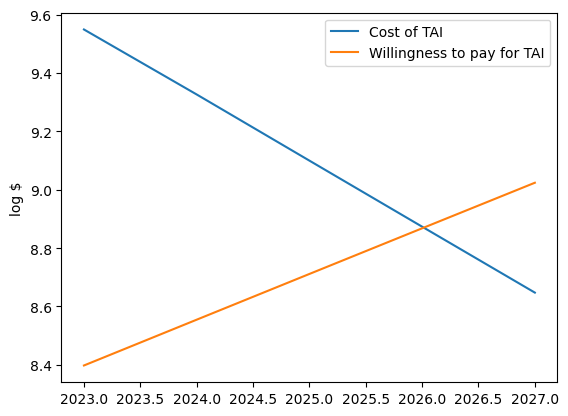

-
-
## SAMPLE RUN 2 ##
It takes 27.6 log FLOP (~4 octillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.8 log FLOP (~6 quintillion) per 2022$USD. Every 2.1 years they get 2x cheaper, to a maximum of 24.9 log FLOP (~7 septillion) per 2022$USD.
We are initially willing to pay 9.0 log 2022$USD (~1 billion). This doubles every 3.2 years to a max of 0.025% of GDP (initially ~6 billion 2022$USD). GDP grows at a rate of 1.031x per year.
---
Year: 2023 - 27.7 max log FLOP (5 octillion) available - TAI takes 27.6 log FLOP (4 octillion) - log $ 8.8 to buy TAI (642 million) vs. willingness to pay log $ 8.9 (876 million) - 18.8 log FLOP per $ (6 quintillion) (Effective 2023-logFLOP: 27.7)
-- algorithms p_nonscaling_issue p=0.4 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.8 -> Nonscaling delay occured
-- -- this delay is 9 years (total delay 9 years)
-- data p_nonscaling_issue p=0.0 -> Nons

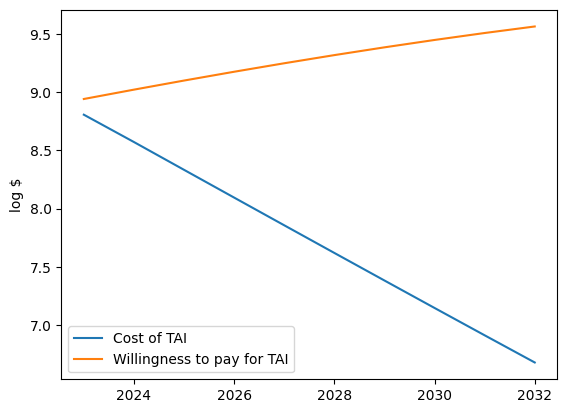

-
-
## SAMPLE RUN 3 ##
It takes 32.6 log FLOP (~398 nonillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 19.0 log FLOP (~11 quintillion) per 2022$USD. Every 2.1 years they get 2x cheaper, to a maximum of 22.8 log FLOP (~68 sextillion) per 2022$USD.
We are initially willing to pay 9.1 log 2022$USD (~1 billion). This doubles every 2.7 years to a max of 0.103868% of GDP (initially ~24 billion 2022$USD). GDP grows at a rate of 1.016x per year.
---
Year: 2023 - 28.1 max log FLOP (13 octillion) available - TAI takes 32.6 log FLOP (398 nonillion) - log $ 13.6 to buy TAI (36 trillion) vs. willingness to pay log $ 9.1 (1 billion) - 19.0 log FLOP per $ (11 quintillion) (Effective 2023-logFLOP: 28.1)
Year: 2024 - 28.3 max log FLOP (22 octillion) available - TAI takes 32.5 log FLOP (285 nonillion) - log $ 13.3 to buy TAI (19 trillion) vs. willingness to pay log $ 9.2 (1 billion) - 19.2 log FLOP per $ (15 quint

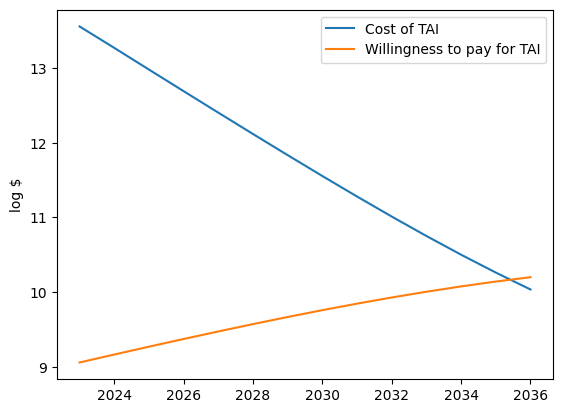

-
-
## RUN TIMELINES MODEL ##
Generating Bayes net with 5 cores...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 335.78it/s]


Shuffling data...
Writing data...
Waiting for other cores...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 612.43it/s]

...Collected!
Caching in-memory...
...Cached!
Writing cache to file `caches/tai_years.sqcache`...
...Cached!
...Reducing
...Reduced!
...All done!
-
## DISTRIBUTION OF TAI ARRIVAL DATE ##
['5%: 2028',
 '10%: 2030',
 '15%: 2031',
 '20%: 2033',
 '25%: 2034',
 '35%: 2036',
 '50%: 2040',
 '60%: 2043',
 '75%: 2052',
 '80%: 2058',
 '90%: >2123',
 '95%: >2123']
(Mean: 2051)
-
-
## DISTRIBUTION OF RELATIVE TAI ARRIVAL DATE ##
['5%: 5 years from now',
 '10%: 7 years from now',
 '15%: 8 years from now',
 '20%: 10 years from now',
 '25%: 11 years from now',
 '35%: 13 years from now',
 '50%: 17 years from now',
 '60%: 20 years from now',
 '75%: 29 years from now',
 '80%: 35 years from now',
 '90%: >100 years from now',
 '95%: >100 years from now']
(Mean: 28 years from now)
-
-
## TAI ARRIVAL DATE BY BIN ##
This year: 0.4%
2024-2025: 0.7%
2026-2027: 2.6%
2028-2029: 6.7%
2030-2034: 20.2%
2035-2039: 20.2%
2040-2049: 22.6%
2050-2059: 8.8%
2060-2069: 3.9%
2070-2079: 1.9%
2080-2089: 1.2%
2090-2099: 0.8%


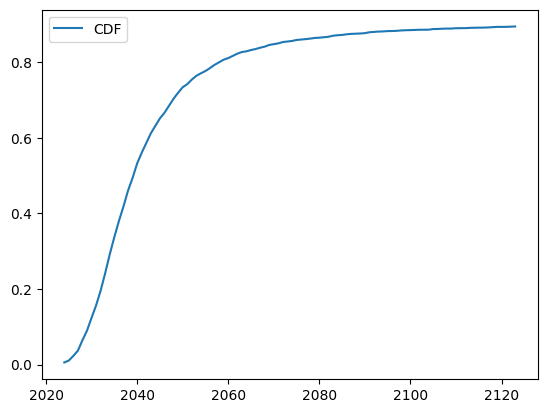

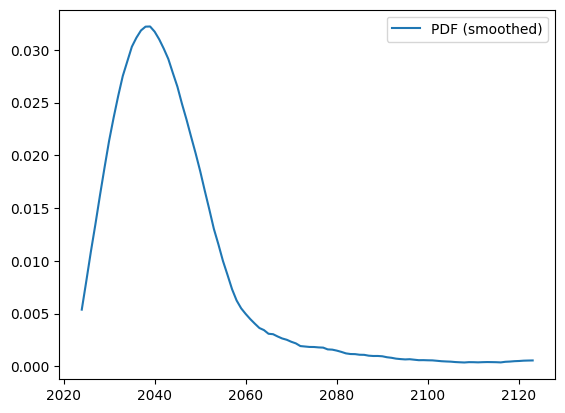

-
-
## TAI FLOP SIZE ##
{1: 23.2,
 5: 24.7,
 10: 25.4,
 20: 26.3,
 30: 27.0,
 40: 27.9,
 50: 29.1,
 60: 31.3,
 70: 33.3,
 80: 35.6,
 90: 39.2,
 95: 42.5,
 99: 46.8}
(Mean: 31.0)


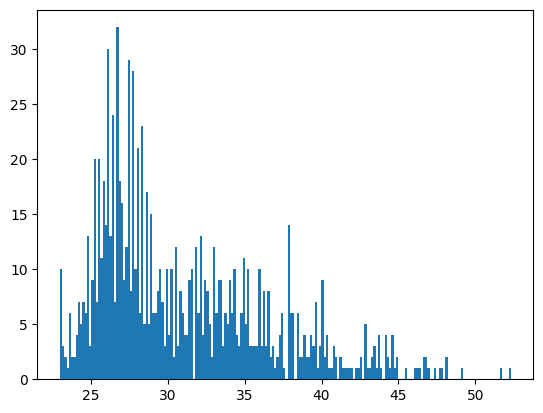

-
-
## MIN REDUCTION: 2 ##
-
## MAX REDUCTION ##
{1: 20.9,
 5: 14.6,
 10: 12.2,
 20: 9.9,
 30: 8.4,
 40: 7.6,
 50: 6.8,
 60: 6.0,
 70: 5.2,
 80: 4.5,
 90: 3.7,
 95: 3.0,
 99: 2.2}
(Mean: 7.5)


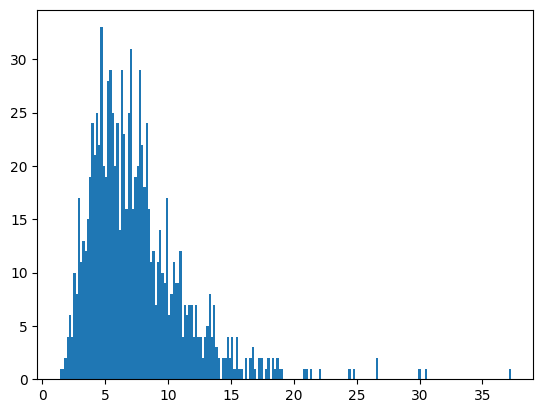

-
-
## MIN ALGO DOUBLING RATE: 1 ##
-
## MAX ALGO DOUBLING RATE: 3 ##
-
## INITIAL FLOP PER DOLLAR ##
{1: 17.7,
 5: 18.0,
 10: 18.1,
 20: 18.3,
 30: 18.4,
 40: 18.5,
 50: 18.6,
 60: 18.7,
 70: 18.8,
 80: 18.9,
 90: 19.1,
 95: 19.2,
 99: 19.5}
(Mean: 18.6)


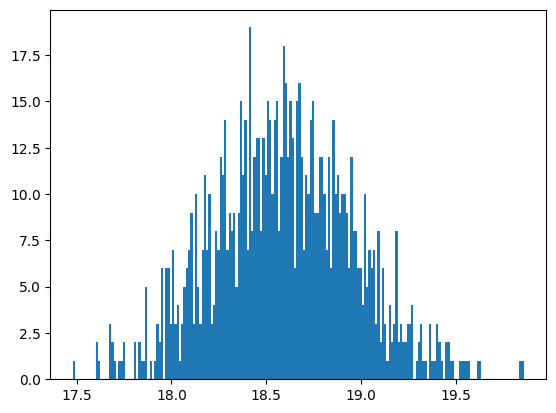

-
-
## FLOP HALVING RATE ##
{1: 5.3,
 5: 4.3,
 10: 3.8,
 20: 3.3,
 30: 3.0,
 40: 2.7,
 50: 2.5,
 60: 2.3,
 70: 2.1,
 80: 1.9,
 90: 1.6,
 95: 1.4,
 99: 1.2}
(Mean: 2.6)


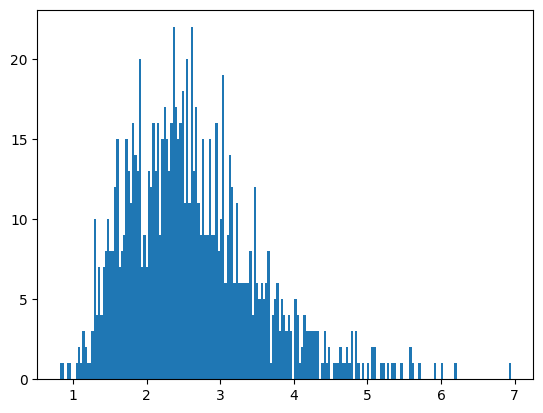

-
-
## MAX FLOP PER DOLLAR ##
{1: 20.3,
 5: 21.0,
 10: 21.4,
 20: 22.0,
 30: 22.5,
 40: 22.9,
 50: 23.3,
 60: 23.7,
 70: 24.2,
 80: 24.7,
 90: 25.5,
 95: 26.1,
 99: 27.2}
(Mean: 23.4)


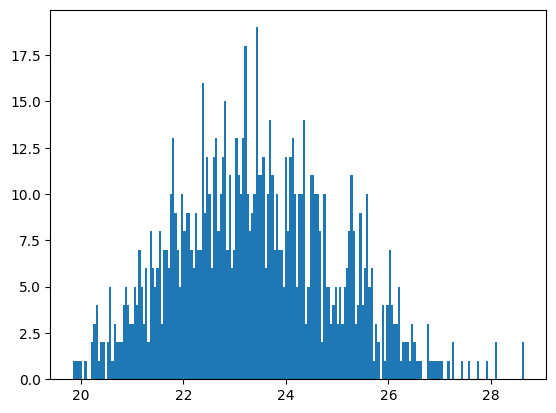

-
-
## INITIAL PAY ##
{1: 8.0,
 5: 8.2,
 10: 8.3,
 20: 8.4,
 30: 8.5,
 40: 8.6,
 50: 8.6,
 60: 8.7,
 70: 8.8,
 80: 8.9,
 90: 9.1,
 95: 9.2,
 99: 9.4}
(Mean: 8.7)


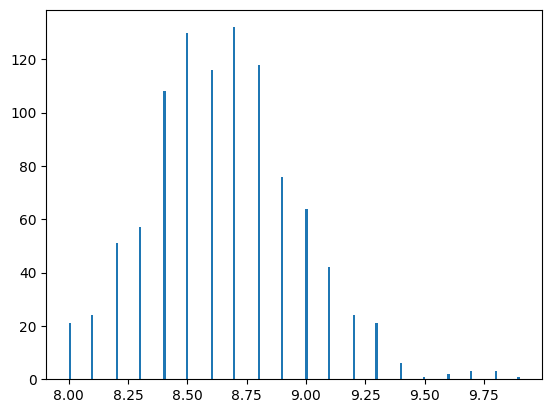

-
-
## GDP GROWTH ##
{1: 1.0,
 5: 1.01,
 10: 1.01,
 20: 1.02,
 30: 1.02,
 40: 1.02,
 50: 1.02,
 60: 1.02,
 70: 1.03,
 80: 1.03,
 90: 1.03,
 95: 1.04,
 99: 1.04}
(Mean: 1.0)


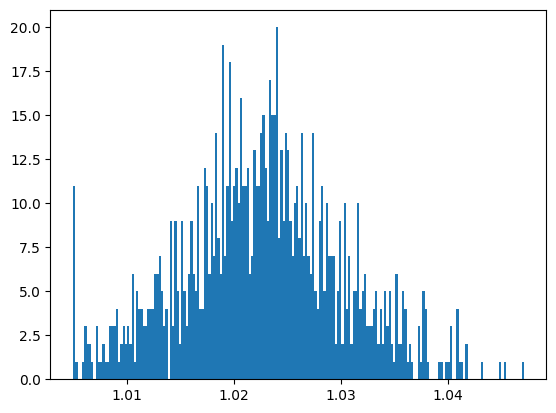

-
-
## MAX GDP FRAC ##
{1: 0.00025,
 5: 0.00025,
 10: 0.00025,
 20: 0.00025,
 30: 0.00025,
 40: 0.00031,
 50: 0.00038,
 60: 0.00049,
 70: 0.00066,
 80: 0.00096,
 90: 0.00196,
 95: 0.00327,
 99: 0.00892}
(Mean: 0.0)


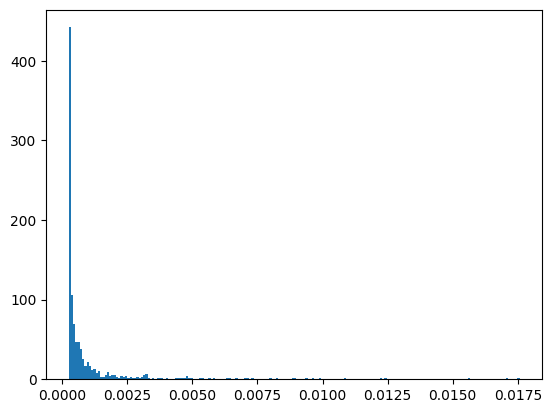

-
-
## SPEND DOUBLING TIME ##
{1: 12.4,
 5: 8.2,
 10: 6.6,
 20: 4.9,
 30: 4.0,
 40: 3.4,
 50: 2.9,
 60: 2.4,
 70: 2.1,
 80: 1.7,
 90: 1.3,
 95: 1.0,
 99: 0.9}
(Mean: 3.5)


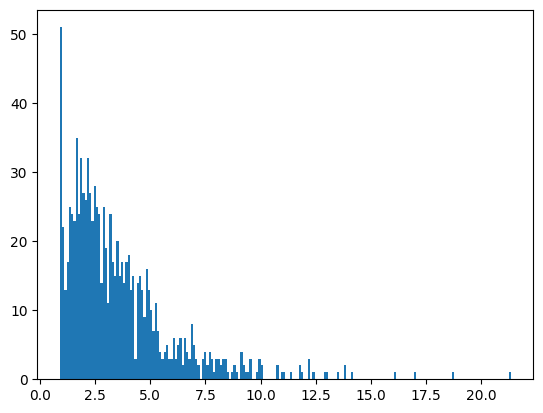

-
-
-
-
## GDP Over Time ##


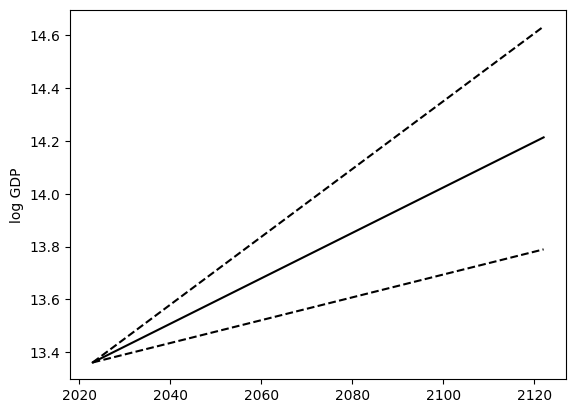

Year: 2023 - GDP log 2022$USD 13.4 (~23 trillion) 90% CI 13.4 (~23 trillion) - 13.4 (~23 trillion)
Year: 2024 - GDP log 2022$USD 13.4 (~23 trillion) 90% CI 13.4 (~23 trillion) - 13.4 (~24 trillion)
Year: 2025 - GDP log 2022$USD 13.4 (~24 trillion) 90% CI 13.4 (~23 trillion) - 13.4 (~24 trillion)
Year: 2026 - GDP log 2022$USD 13.4 (~24 trillion) 90% CI 13.4 (~24 trillion) - 13.4 (~25 trillion)
Year: 2027 - GDP log 2022$USD 13.4 (~25 trillion) 90% CI 13.4 (~24 trillion) - 13.4 (~26 trillion)
Year: 2028 - GDP log 2022$USD 13.4 (~25 trillion) 90% CI 13.4 (~24 trillion) - 13.4 (~27 trillion)
Year: 2029 - GDP log 2022$USD 13.4 (~26 trillion) 90% CI 13.4 (~24 trillion) - 13.4 (~27 trillion)
Year: 2030 - GDP log 2022$USD 13.4 (~26 trillion) 90% CI 13.4 (~25 trillion) - 13.5 (~28 trillion)
Year: 2031 - GDP log 2022$USD 13.4 (~27 trillion) 90% CI 13.4 (~25 trillion) - 13.5 (~29 trillion)
Year: 2032 - GDP log 2022$USD 13.4 (~27 trillion) 90% CI 13.4 (~25 trillion) - 13.5 (~30 trillion)
Year: 2033

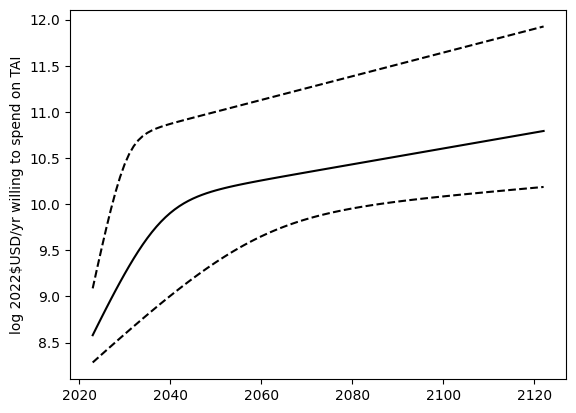

Year: 2023 - willingness log 2022$USD per year 8.6 (~381 million) 90% CI 8.3 (~193 million) - 9.1 (~1 billion)
Year: 2024 - willingness log 2022$USD per year 8.7 (~478 million) 90% CI 8.3 (~213 million) - 9.3 (~2 billion)
Year: 2025 - willingness log 2022$USD per year 8.8 (~600 million) 90% CI 8.4 (~236 million) - 9.5 (~3 billion)
Year: 2026 - willingness log 2022$USD per year 8.9 (~750 million) 90% CI 8.4 (~261 million) - 9.7 (~6 billion)
Year: 2027 - willingness log 2022$USD per year 9.0 (~933 million) 90% CI 8.5 (~289 million) - 9.9 (~9 billion)
Year: 2028 - willingness log 2022$USD per year 9.1 (~1 billion) 90% CI 8.5 (~319 million) - 10.1 (~13 billion)
Year: 2029 - willingness log 2022$USD per year 9.2 (~1 billion) 90% CI 8.5 (~353 million) - 10.3 (~20 billion)
Year: 2030 - willingness log 2022$USD per year 9.2 (~2 billion) 90% CI 8.6 (~390 million) - 10.4 (~27 billion)
Year: 2031 - willingness log 2022$USD per year 9.3 (~2 billion) 90% CI 8.6 (~430 million) - 10.5 (~35 billion)
Y

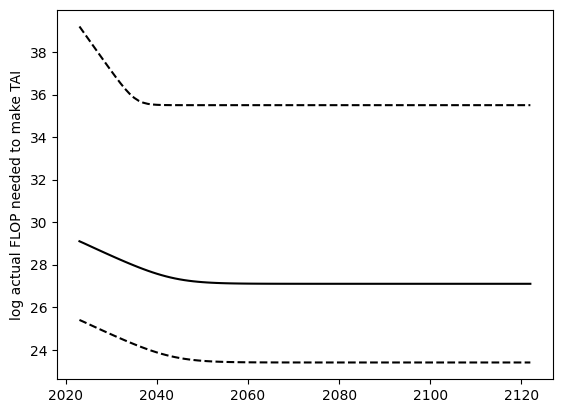

Year: 2023 - log FLOP needed for TAI 29.1 (~126 octillion) 90% CI 25.4 (~25 septillion) - 39.2 (~2 million decillion)
Year: 2024 - log FLOP needed for TAI 29.0 (~101 octillion) 90% CI 25.3 (~20 septillion) - 38.9 (~793 thousand decillion)
Year: 2025 - log FLOP needed for TAI 28.9 (~81 octillion) 90% CI 25.2 (~16 septillion) - 38.6 (~397 thousand decillion)
Year: 2026 - log FLOP needed for TAI 28.8 (~64 octillion) 90% CI 25.1 (~13 septillion) - 38.3 (~198 thousand decillion)
Year: 2027 - log FLOP needed for TAI 28.7 (~51 octillion) 90% CI 25.0 (~10 septillion) - 38.0 (~99 thousand decillion)
Year: 2028 - log FLOP needed for TAI 28.6 (~41 octillion) 90% CI 24.9 (~8 septillion) - 37.7 (~50 thousand decillion)
Year: 2029 - log FLOP needed for TAI 28.5 (~33 octillion) 90% CI 24.8 (~7 septillion) - 37.4 (~25 thousand decillion)
Year: 2030 - log FLOP needed for TAI 28.4 (~26 octillion) 90% CI 24.7 (~5 septillion) - 37.1 (~13 thousand decillion)
Year: 2031 - log FLOP needed for TAI 28.3 (~21 o

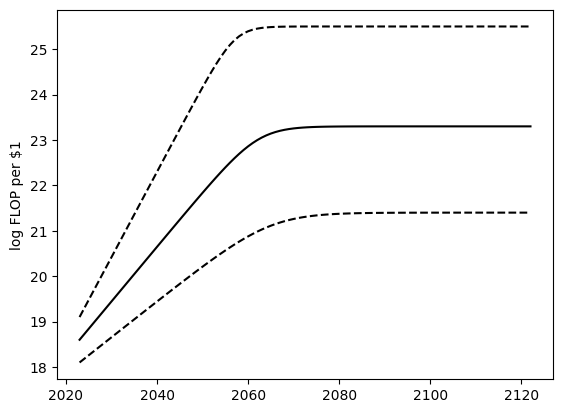

Year: 2023 - log FLOP per 2022$1USD 18.6 (~4 quintillion) 90% CI 18.1 (~1 quintillion) - 19.1 (~13 quintillion)
Year: 2024 - log FLOP per 2022$1USD 18.7 (~5 quintillion) 90% CI 18.2 (~2 quintillion) - 19.3 (~19 quintillion)
Year: 2025 - log FLOP per 2022$1USD 18.8 (~7 quintillion) 90% CI 18.3 (~2 quintillion) - 19.5 (~30 quintillion)
Year: 2026 - log FLOP per 2022$1USD 19.0 (~9 quintillion) 90% CI 18.3 (~2 quintillion) - 19.7 (~46 quintillion)
Year: 2027 - log FLOP per 2022$1USD 19.1 (~12 quintillion) 90% CI 18.4 (~3 quintillion) - 19.9 (~71 quintillion)
Year: 2028 - log FLOP per 2022$1USD 19.2 (~16 quintillion) 90% CI 18.5 (~3 quintillion) - 20.0 (~110 quintillion)
Year: 2029 - log FLOP per 2022$1USD 19.3 (~21 quintillion) 90% CI 18.6 (~4 quintillion) - 20.2 (~169 quintillion)
Year: 2030 - log FLOP per 2022$1USD 19.4 (~28 quintillion) 90% CI 18.7 (~5 quintillion) - 20.4 (~261 quintillion)
Year: 2031 - log FLOP per 2022$1USD 19.6 (~37 quintillion) 90% CI 18.7 (~5 quintillion) - 20.6 (~

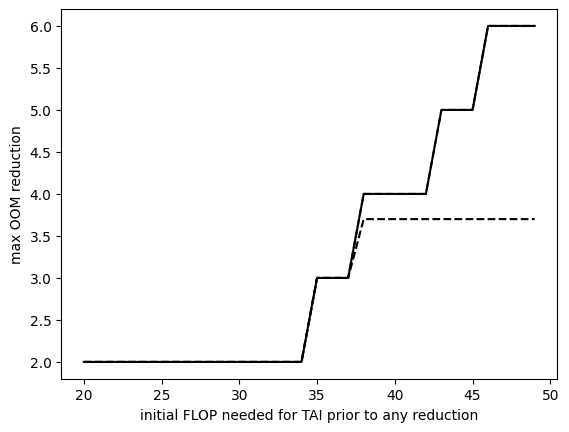

TAI log FLOP 20 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 21 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 22 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 23 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 24 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 25 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 26 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 27 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 28 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 29 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 30 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 31 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 32 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 33 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 34 -> 2.0 OOM reductions possible (

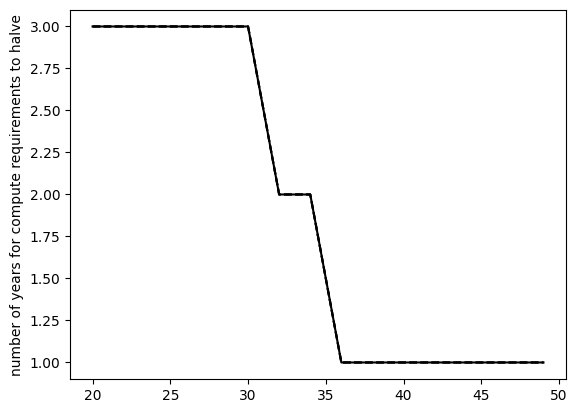

TAI log FLOP 20 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 21 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 22 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 23 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 24 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 25 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 26 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 27 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 28 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 29 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 30 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 31 -> algo doubling rate 2.5yrs (90% CI: 2.5 to 2.5)
TAI log FLOP 32 -> algo doubling rate 2.0yrs (90% CI: 2.0 to 2.0)
TAI log FLOP 33 -> algo doubling rate 2.0yrs (90% CI: 2.0 to 2.0)
TAI log FLOP 34 -> algo doubling rate 2.0yrs (90% CI: 2.0 to 2.0)
TAI log FL

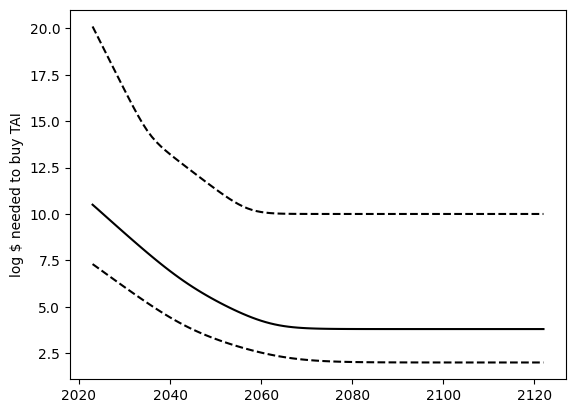

Year: 2023 - 10.5 log 2022$USD to buy TAI (~32 billion) 90% CI 7.3 (~20 million) - 20.1 (~126 quintillion)
Year: 2024 - 10.3 log 2022$USD to buy TAI (~19 billion) 90% CI 7.1 (~13 million) - 19.6 (~41 quintillion)
Year: 2025 - 10.1 log 2022$USD to buy TAI (~12 billion) 90% CI 6.9 (~9 million) - 19.1 (~13 quintillion)
Year: 2026 - 9.8 log 2022$USD to buy TAI (~7 billion) 90% CI 6.8 (~6 million) - 18.6 (~4 quintillion)
Year: 2027 - 9.6 log 2022$USD to buy TAI (~4 billion) 90% CI 6.6 (~4 million) - 18.1 (~1 quintillion)
Year: 2028 - 9.4 log 2022$USD to buy TAI (~3 billion) 90% CI 6.4 (~3 million) - 17.7 (~454 quadrillion)
Year: 2029 - 9.2 log 2022$USD to buy TAI (~2 billion) 90% CI 6.2 (~2 million) - 17.2 (~148 quadrillion)
Year: 2030 - 9.0 log 2022$USD to buy TAI (~947 million) 90% CI 6.1 (~1 million) - 16.7 (~49 quadrillion)
Year: 2031 - 8.8 log 2022$USD to buy TAI (~576 million) 90% CI 5.9 (~778 thousand) - 16.2 (~16 quadrillion)
Year: 2032 - 8.5 log 2022$USD to buy TAI (~352 million) 9

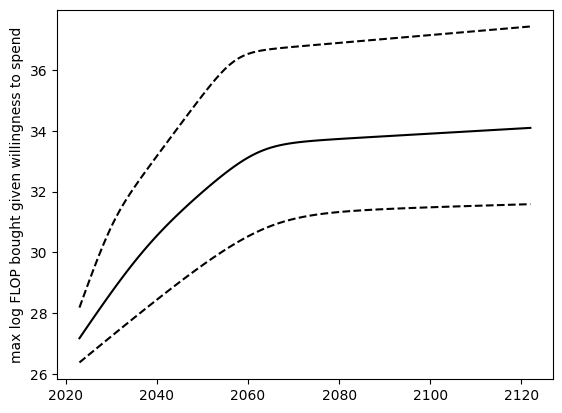

Year: 2023 - max log FLOP 27.2 (~2 octillion) 90% CI 26.4 (~243 septillion) - 28.2 (~15 octillion)
Year: 2024 - max log FLOP 27.4 (~3 octillion) 90% CI 26.5 (~322 septillion) - 28.6 (~40 octillion)
Year: 2025 - max log FLOP 27.6 (~4 octillion) 90% CI 26.6 (~428 septillion) - 29.0 (~102 octillion)
Year: 2026 - max log FLOP 27.8 (~7 octillion) 90% CI 26.8 (~568 septillion) - 29.4 (~255 octillion)
Year: 2027 - max log FLOP 28.1 (~11 octillion) 90% CI 26.9 (~754 septillion) - 29.8 (~626 octillion)
Year: 2028 - max log FLOP 28.3 (~18 octillion) 90% CI 27.0 (~1 octillion) - 30.2 (~1 nonillion)
Year: 2029 - max log FLOP 28.5 (~30 octillion) 90% CI 27.1 (~1 octillion) - 30.5 (~3 nonillion)
Year: 2030 - max log FLOP 28.7 (~49 octillion) 90% CI 27.2 (~2 octillion) - 30.8 (~7 nonillion)
Year: 2031 - max log FLOP 28.9 (~78 octillion) 90% CI 27.4 (~2 octillion) - 31.1 (~14 nonillion)
Year: 2032 - max log FLOP 29.1 (~124 octillion) 90% CI 27.5 (~3 octillion) - 31.4 (~26 nonillion)
Year: 2033 - max l

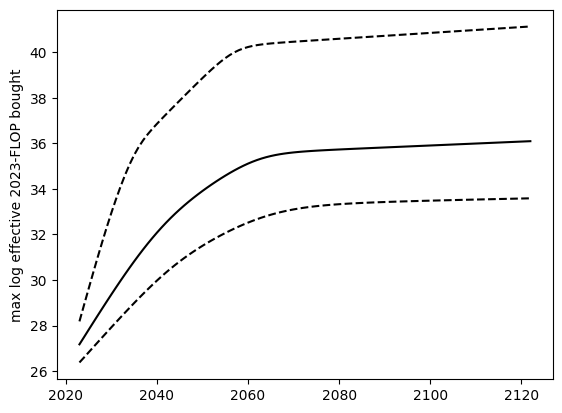

Year: 2023 - max log effective 2023-FLOP 27.2 (~2 octillion) 90% CI 26.4 (~243 septillion) - 28.2 (~15 octillion)
Year: 2024 - max log effective 2023-FLOP 27.5 (~3 octillion) 90% CI 26.6 (~401 septillion) - 28.9 (~80 octillion)
Year: 2025 - max log effective 2023-FLOP 27.8 (~6 octillion) 90% CI 26.8 (~669 septillion) - 29.6 (~407 octillion)
Year: 2026 - max log effective 2023-FLOP 28.1 (~13 octillion) 90% CI 27.0 (~1 octillion) - 30.3 (~2 nonillion)
Year: 2027 - max log effective 2023-FLOP 28.4 (~28 octillion) 90% CI 27.3 (~2 octillion) - 31.0 (~10 nonillion)
Year: 2028 - max log effective 2023-FLOP 28.8 (~57 octillion) 90% CI 27.5 (~3 octillion) - 31.7 (~47 nonillion)
Year: 2029 - max log effective 2023-FLOP 29.1 (~115 octillion) 90% CI 27.7 (~5 octillion) - 32.3 (~210 nonillion)
Year: 2030 - max log effective 2023-FLOP 29.4 (~233 octillion) 90% CI 27.9 (~8 octillion) - 32.9 (~880 nonillion)
Year: 2031 - max log effective 2023-FLOP 29.7 (~466 octillion) 90% CI 28.1 (~14 octillion) - 3

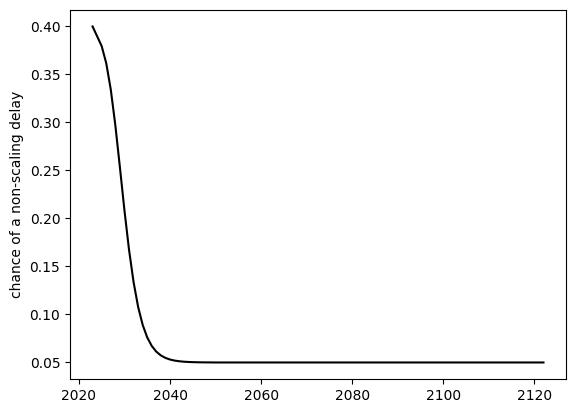

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 40%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 39%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 38%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 36%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 33%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 25%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 21%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 17%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 13%
Year: 2033

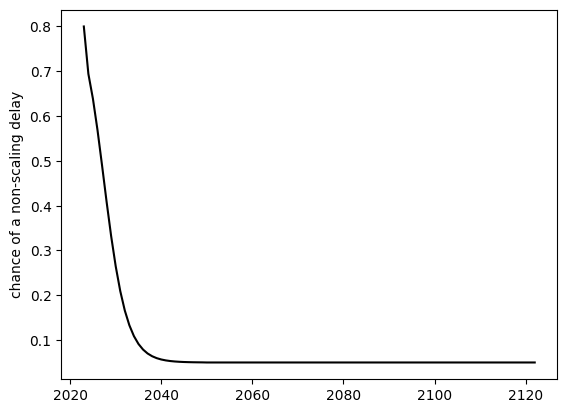

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 80%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 69%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 64%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 57%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 49%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 41%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 33%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 26%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 21%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 17%
Year: 2033

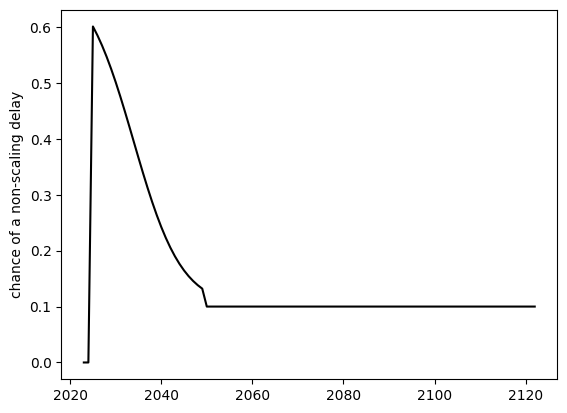

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 0%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 0%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 60%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 58%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 57%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 55%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 53%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 50%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 48%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 45%
Year: 2033 -

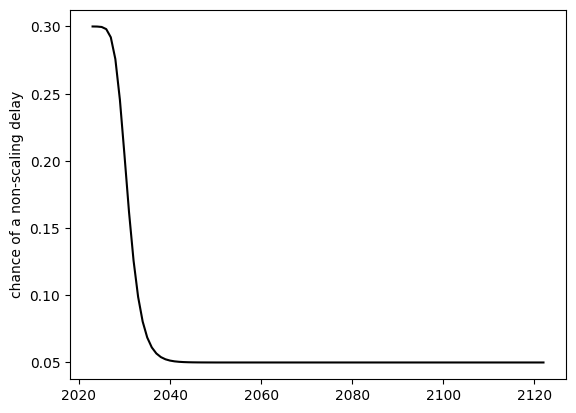

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 29%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 28%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 25%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 20%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 16%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 13%
Year: 2033

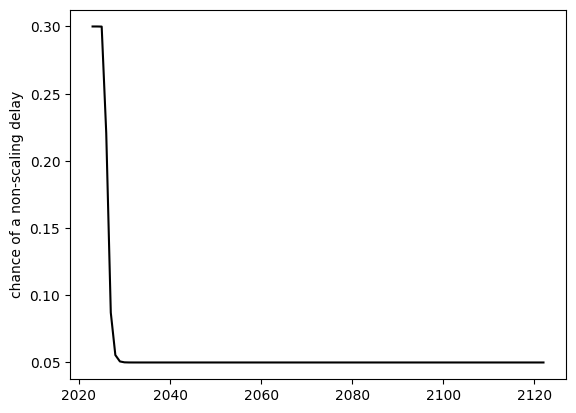

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 22%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 9%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 6%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2033 - cha

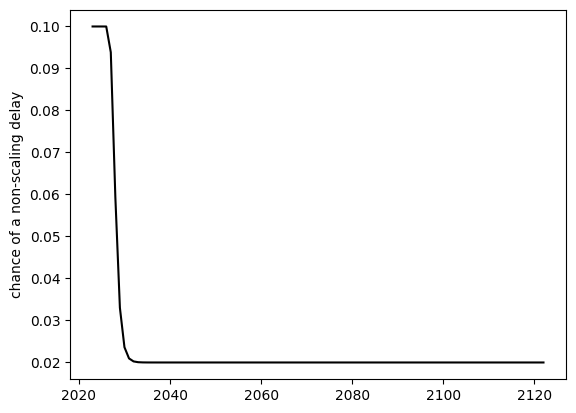

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 9%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 6%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 3%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 2%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 2%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 2%
Year: 2033 - cha

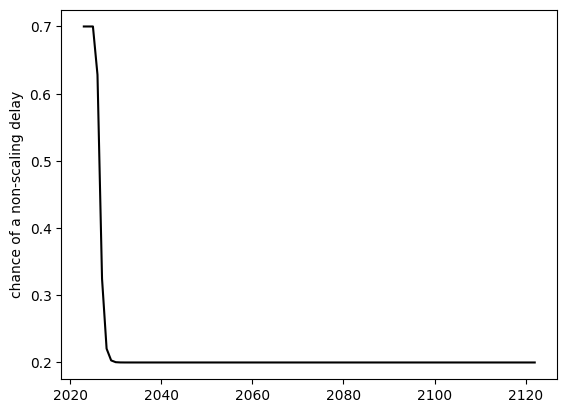

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 70%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 70%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 70%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 63%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 32%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 22%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 20%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 20%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 20%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 20%
Year: 2033

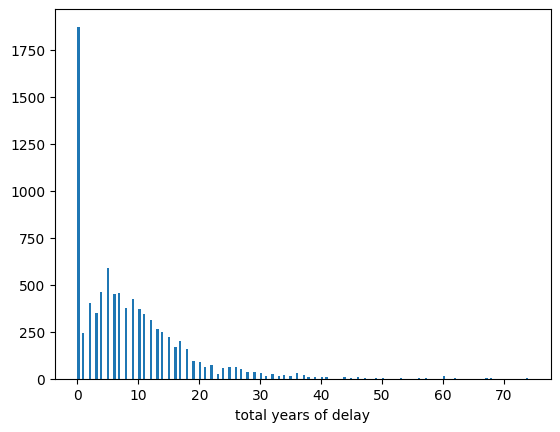

In [9]:
variables['RUNS'] = RUNS
variables['CURRENT_YEAR'] = CURRENT_YEAR
variables['MAX_YEAR'] = MAX_YEAR

run_timelines_model(variables,
                    cores=5,
                    runs=variables['RUNS'],
                    #dump_cache_file='caches/tai_years_metaculus_parity')
                    dump_cache_file='caches/tai_years')


-
-
## SAMPLE RUN 4 ##
It takes 29.3 log FLOP (~200 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.6 log FLOP (~4 quintillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 26.3 log FLOP (~197 septillion) per 2022$USD.
We are initially willing to pay 8.5 log 2022$USD (~314 million). This doubles every 3.9 years to a max of 0.242093% of GDP (initially ~56 billion 2022$USD). GDP grows at a rate of 1.028x per year.
---
Year: 2023 - 27.1 max log FLOP (1 octillion) available - TAI takes 29.3 log FLOP (200 octillion) - log $ 10.7 to buy TAI (50 billion) vs. willingness to pay log $ 8.5 (313 million) - 18.6 log FLOP per $ (4 quintillion) (Effective 2023-logFLOP: 27.1)
Year: 2024 - 27.3 max log FLOP (2 octillion) available - TAI takes 29.2 log FLOP (160 octillion) - log $ 10.5 to buy TAI (30 billion) vs. willingness to pay log $ 8.6 (373 million) - 18.7 log FLOP per $ (5 quint

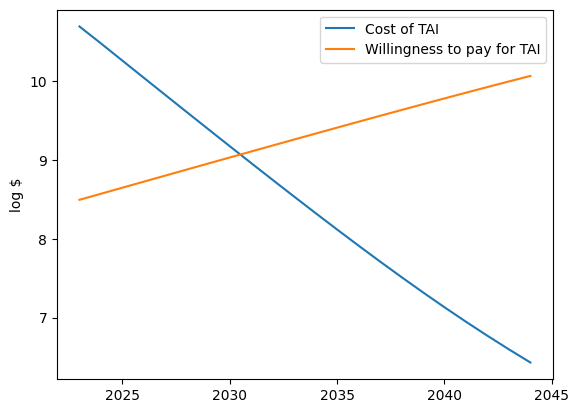

-
-
## SAMPLE RUN 5 ##
It takes 34.8 log FLOP (~63 decillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 17.9 log FLOP (~840 quadrillion) per 2022$USD. Every 2.2 years they get 2x cheaper, to a maximum of 22.8 log FLOP (~61 sextillion) per 2022$USD.
We are initially willing to pay 9.4 log 2022$USD (~3 billion). This doubles every 5.4 years to a max of 0.093782% of GDP (initially ~22 billion 2022$USD). GDP grows at a rate of 1.033x per year.
---
Year: 2023 - 27.3 max log FLOP (2 octillion) available - TAI takes 34.8 log FLOP (63 decillion) - log $ 16.9 to buy TAI (75 quadrillion) vs. willingness to pay log $ 9.4 (2 billion) - 17.9 log FLOP per $ (840 quadrillion) (Effective 2023-logFLOP: 27.3)
Year: 2024 - 27.5 max log FLOP (3 octillion) available - TAI takes 34.6 log FLOP (40 decillion) - log $ 16.5 to buy TAI (35 quadrillion) vs. willingness to pay log $ 9.4 (3 billion) - 18.1 log FLOP per $ (1 qui

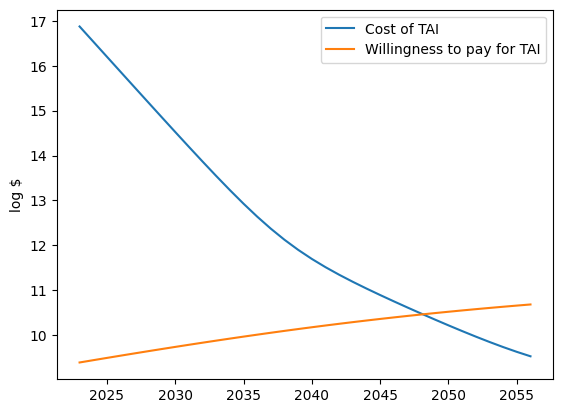

-
-
## SAMPLE RUN 6 ##
It takes 26.1 log FLOP (~126 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.9 log FLOP (~8 quintillion) per 2022$USD. Every 2.9 years they get 2x cheaper, to a maximum of 24.4 log FLOP (~2 septillion) per 2022$USD.
We are initially willing to pay 8.7 log 2022$USD (~461 million). This doubles every 10.7 years to a max of 0.025% of GDP (initially ~6 billion 2022$USD). GDP grows at a rate of 1.031x per year.
---
Year: 2023 - 27.5 max log FLOP (3 octillion) available - TAI takes 26.1 log FLOP (126 septillion) - log $ 7.2 to buy TAI (16 million) vs. willingness to pay log $ 8.6 (427 million) - 18.9 log FLOP per $ (8 quintillion) (Effective 2023-logFLOP: 27.5)
-- algorithms p_nonscaling_issue p=0.4 -> Nonscaling delay occured
-- -- this delay is 4 years (total delay 4 years)
-- infra p_nonscaling_issue p=0.8 -> Nonscaling delay occured
-- -- this delay is 3 years (total del

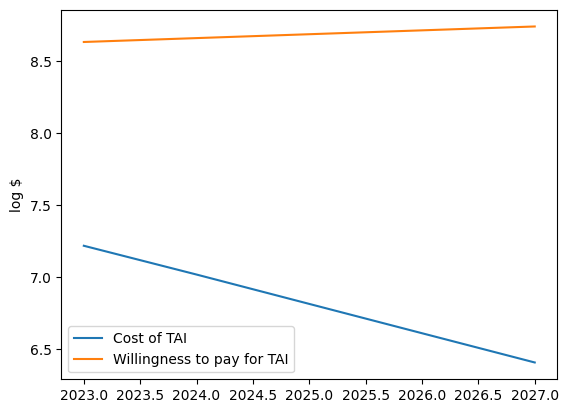

-
-
## SAMPLE RUN 7 ##
It takes 37.2 log FLOP (~16 thousand decillion) for transformative capabilities.
Every 1.0 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.8 log FLOP (~7 quintillion) per 2022$USD. Every 2.2 years they get 2x cheaper, to a maximum of 25.7 log FLOP (~45 septillion) per 2022$USD.
We are initially willing to pay 8.7 log 2022$USD (~482 million). This doubles every 5.9 years to a max of 0.056241% of GDP (initially ~13 billion 2022$USD). GDP grows at a rate of 1.022x per year.
---
Year: 2023 - 27.5 max log FLOP (3 octillion) available - TAI takes 37.2 log FLOP (16 thousand decillion) - log $ 18.4 to buy TAI (2 quintillion) vs. willingness to pay log $ 8.7 (465 million) - 18.8 log FLOP per $ (7 quintillion) (Effective 2023-logFLOP: 27.5)
Year: 2024 - 27.7 max log FLOP (5 octillion) available - TAI takes 36.9 log FLOP (8 thousand decillion) - log $ 17.9 to buy TAI (880 quadrillion) vs. willingness to pay log $ 8.7 (521 million) 

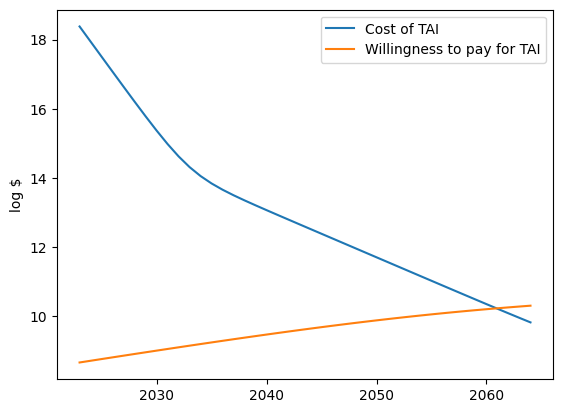

-
-
## SAMPLE RUN 8 ##
It takes 25.6 log FLOP (~40 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.4 log FLOP (~2 quintillion) per 2022$USD. Every 2.7 years they get 2x cheaper, to a maximum of 26.1 log FLOP (~132 septillion) per 2022$USD.
We are initially willing to pay 8.9 log 2022$USD (~751 million). This doubles every 2.4 years to a max of 0.059802% of GDP (initially ~14 billion 2022$USD). GDP grows at a rate of 1.024x per year.
---
Year: 2023 - 27.2 max log FLOP (2 octillion) available - TAI takes 25.6 log FLOP (40 septillion) - log $ 7.2 to buy TAI (16 million) vs. willingness to pay log $ 8.9 (712 million) - 18.4 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.2)
-- algorithms p_nonscaling_issue p=0.4 -> Nonscaling delay occured
-- -- this delay is 3 years (total delay 3 years)
-- infra p_nonscaling_issue p=0.8 -> Nonscaling delay occured
-- -- this delay is 3 years (total 

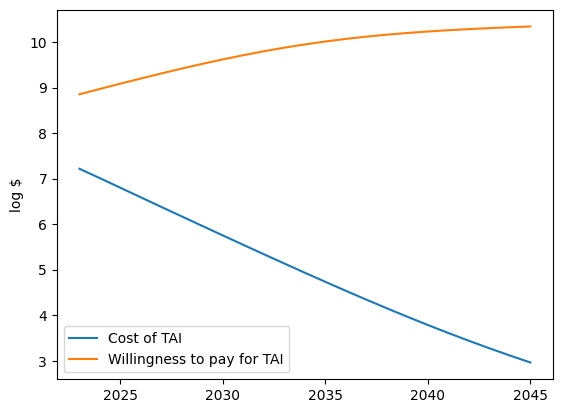

-
-
## SAMPLE RUN 9 ##
It takes 25.6 log FLOP (~40 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 1.3 years they get 2x cheaper, to a maximum of 23.5 log FLOP (~335 sextillion) per 2022$USD.
We are initially willing to pay 8.8 log 2022$USD (~708 million). This doubles every 3.9 years to a max of 0.028166% of GDP (initially ~6 billion 2022$USD). GDP grows at a rate of 1.027x per year.
---
Year: 2023 - 27.1 max log FLOP (1 octillion) available - TAI takes 25.6 log FLOP (40 septillion) - log $ 7.3 to buy TAI (20 million) vs. willingness to pay log $ 8.8 (638 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.1)
-- algorithms p_nonscaling_issue p=0.4 -> Nonscaling delay occured
-- -- this delay is 3 years (total delay 3 years)
-- infra p_nonscaling_issue p=0.8 -> Nonscaling delay occured
-- -- this delay is 6 years (total d

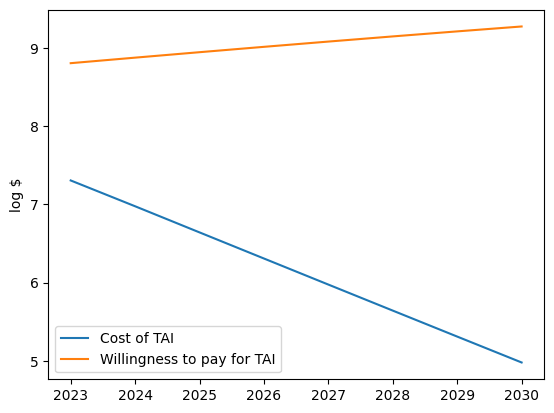

-
-
## SAMPLE RUN 10 ##
It takes 26.2 log FLOP (~158 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 17.9 log FLOP (~777 quadrillion) per 2022$USD. Every 4.1 years they get 2x cheaper, to a maximum of 23.9 log FLOP (~765 sextillion) per 2022$USD.
We are initially willing to pay 8.7 log 2022$USD (~469 million). This doubles every 3.9 years to a max of 0.03134% of GDP (initially ~7 billion 2022$USD). GDP grows at a rate of 1.032x per year.
---
Year: 2023 - 26.5 max log FLOP (342 septillion) available - TAI takes 26.2 log FLOP (158 septillion) - log $ 8.3 to buy TAI (204 million) vs. willingness to pay log $ 8.6 (440 million) - 17.9 log FLOP per $ (777 quadrillion) (Effective 2023-logFLOP: 26.5)
-- algorithms p_nonscaling_issue p=0.4 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.8 -> Nonscaling delay occured
-- -- this delay is 4 years (total delay 4 years)
-- data p_nonscaling

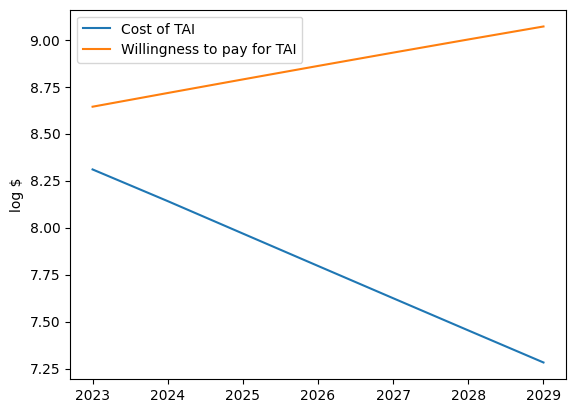

-
-
## SAMPLE RUN 11 ##
It takes 36.2 log FLOP (~2 thousand decillion) for transformative capabilities.
Every 1.0 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.0 log FLOP (~1 quintillion) per 2022$USD. Every 2.1 years they get 2x cheaper, to a maximum of 21.9 log FLOP (~8 sextillion) per 2022$USD.
We are initially willing to pay 8.4 log 2022$USD (~251 million). This doubles every 1.0 years until 2025, and then doubles every 0.9 years to a max of 0.608077% of GDP (initially ~140 billion 2022$USD). GDP grows at a rate of 1.035x per year.
---
Year: 2023 - 26.4 max log FLOP (276 septillion) available - TAI takes 36.2 log FLOP (2 thousand decillion) - log $ 18.2 to buy TAI (1 quintillion) vs. willingness to pay log $ 8.4 (250 million) - 18.0 log FLOP per $ (1 quintillion) (Effective 2023-logFLOP: 26.4)
Year: 2024 - 26.9 max log FLOP (764 septillion) available - TAI takes 35.9 log FLOP (794 decillion) - log $ 17.7 to buy TAI (518 quadrillion) vs. 

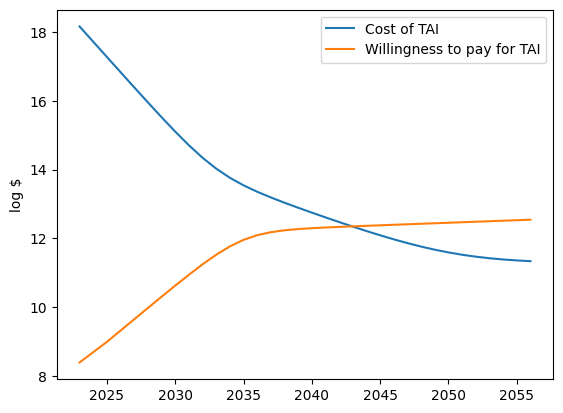

-
-
## SAMPLE RUN 12 ##
It takes 27.6 log FLOP (~4 octillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.7 log FLOP (~5 quintillion) per 2022$USD. Every 3.2 years they get 2x cheaper, to a maximum of 24.1 log FLOP (~1 septillion) per 2022$USD.
We are initially willing to pay 8.4 log 2022$USD (~241 million). This doubles every 1.6 years to a max of 0.025% of GDP (initially ~6 billion 2022$USD). GDP grows at a rate of 1.012x per year.
---
Year: 2023 - 27.0 max log FLOP (1 octillion) available - TAI takes 27.6 log FLOP (4 octillion) - log $ 8.9 to buy TAI (872 million) vs. willingness to pay log $ 8.4 (231 million) - 18.7 log FLOP per $ (5 quintillion) (Effective 2023-logFLOP: 27.0)
Year: 2024 - 27.3 max log FLOP (2 octillion) available - TAI takes 27.5 log FLOP (3 octillion) - log $ 8.8 to buy TAI (564 million) vs. willingness to pay log $ 8.5 (347 million) - 18.8 log FLOP per $ (6 quintillion) (Effe

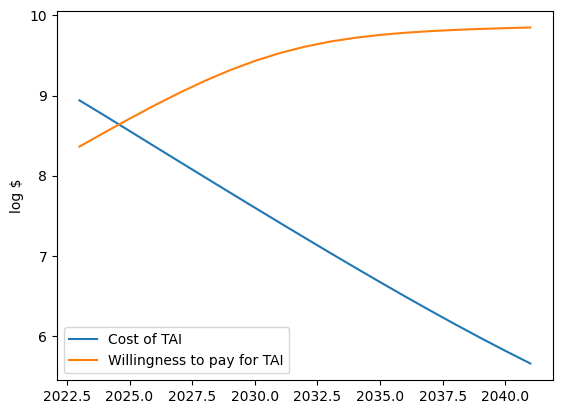

-
-
## SAMPLE RUN 13 ##
It takes 36.5 log FLOP (~3 thousand decillion) for transformative capabilities.
Every 1.0 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.6 log FLOP (~4 quintillion) per 2022$USD. Every 2.6 years they get 2x cheaper, to a maximum of 24.1 log FLOP (~1 septillion) per 2022$USD.
We are initially willing to pay 8.0 log 2022$USD (~99 million). This doubles every 8.1 years to a max of 0.058659% of GDP (initially ~13 billion 2022$USD). GDP grows at a rate of 1.019x per year.
---
Year: 2023 - 26.5 max log FLOP (354 septillion) available - TAI takes 36.5 log FLOP (3 thousand decillion) - log $ 17.9 to buy TAI (880 quadrillion) vs. willingness to pay log $ 8.0 (99 million) - 18.6 log FLOP per $ (4 quintillion) (Effective 2023-logFLOP: 26.5)
Year: 2024 - 26.7 max log FLOP (503 septillion) available - TAI takes 36.2 log FLOP (2 thousand decillion) - log $ 17.5 to buy TAI (338 quadrillion) vs. willingness to pay log $ 8.0 (107 milli

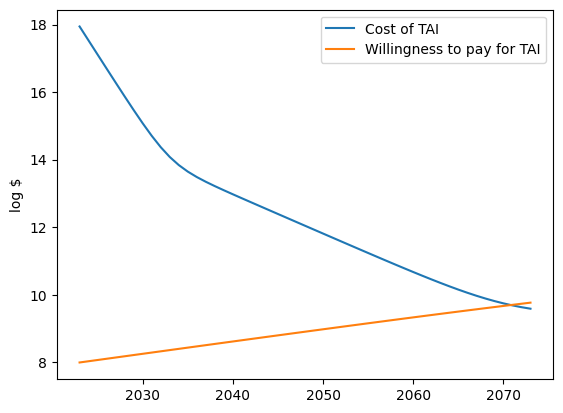

-
-
## SAMPLE RUN 14 ##
It takes 28.0 log FLOP (~10 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.9 log FLOP (~9 quintillion) per 2022$USD. Every 1.4 years they get 2x cheaper, to a maximum of 23.0 log FLOP (~95 sextillion) per 2022$USD.
We are initially willing to pay 8.5 log 2022$USD (~308 million). This doubles every 1.7 years to a max of 0.04927% of GDP (initially ~11 billion 2022$USD). GDP grows at a rate of 1.01x per year.
---
Year: 2023 - 27.4 max log FLOP (3 octillion) available - TAI takes 28.0 log FLOP (10 octillion) - log $ 9.1 to buy TAI (1 billion) vs. willingness to pay log $ 8.5 (300 million) - 18.9 log FLOP per $ (9 quintillion) (Effective 2023-logFLOP: 27.4)
Year: 2024 - 27.8 max log FLOP (7 octillion) available - TAI takes 27.9 log FLOP (8 octillion) - log $ 8.7 to buy TAI (552 million) vs. willingness to pay log $ 8.7 (447 million) - 19.2 log FLOP per $ (15 quintillion)

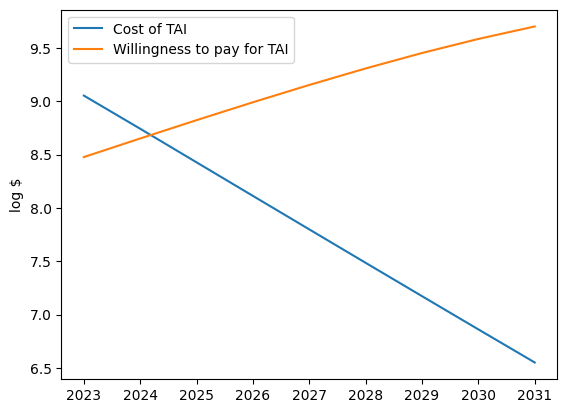

-
-
## SAMPLE RUN 15 ##
It takes 31.2 log FLOP (~16 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.5 log FLOP (~3 quintillion) per 2022$USD. Every 2.3 years they get 2x cheaper, to a maximum of 23.6 log FLOP (~414 sextillion) per 2022$USD.
We are initially willing to pay 8.4 log 2022$USD (~245 million). This doubles every 4.7 years to a max of 0.046584% of GDP (initially ~11 billion 2022$USD). GDP grows at a rate of 1.017x per year.
---
Year: 2023 - 26.9 max log FLOP (755 septillion) available - TAI takes 31.2 log FLOP (16 nonillion) - log $ 12.7 to buy TAI (5 trillion) vs. willingness to pay log $ 8.4 (240 million) - 18.5 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 26.9)
Year: 2024 - 27.1 max log FLOP (1 octillion) available - TAI takes 31.1 log FLOP (12 nonillion) - log $ 12.5 to buy TAI (3 trillion) vs. willingness to pay log $ 8.4 (278 million) - 18.6 log FLOP per $ (4 quin

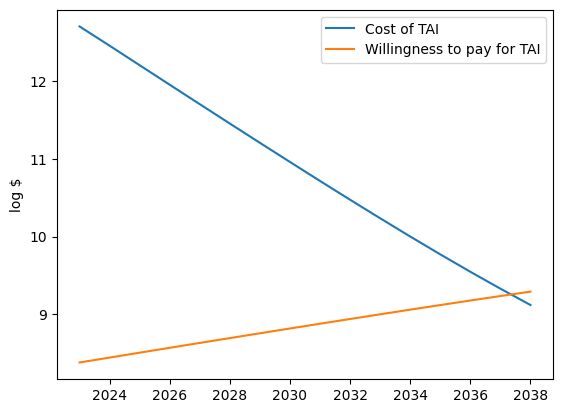

-
-
## SAMPLE RUN 16 ##
It takes 38.1 log FLOP (~126 thousand decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 4 log reductions possible.
FLOP start at a cost of 18.5 log FLOP (~3 quintillion) per 2022$USD. Every 2.3 years they get 2x cheaper, to a maximum of 22.7 log FLOP (~45 sextillion) per 2022$USD.
We are initially willing to pay 9.1 log 2022$USD (~1 billion). This doubles every 4.9 years to a max of 0.270038% of GDP (initially ~62 billion 2022$USD). GDP grows at a rate of 1.029x per year.
---
Year: 2023 - 27.5 max log FLOP (4 octillion) available - TAI takes 38.1 log FLOP (126 thousand decillion) - log $ 19.6 to buy TAI (43 quintillion) vs. willingness to pay log $ 9.1 (1 billion) - 18.5 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 27.5)
Year: 2024 - 27.7 max log FLOP (5 octillion) available - TAI takes 37.8 log FLOP (63 thousand decillion) - log $ 19.2 to buy TAI (16 quintillion) vs. willingness to pay log $ 9.1 (1 billion) - 18

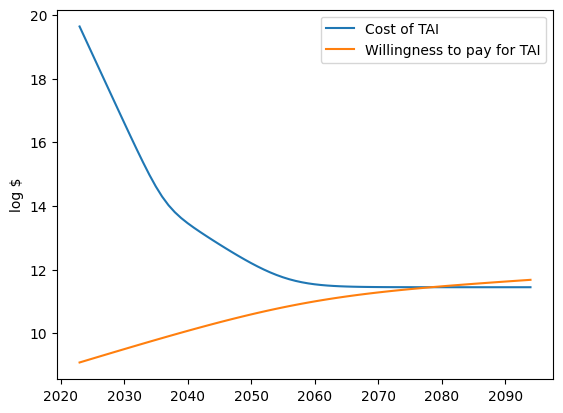

-
-
## SAMPLE RUN 17 ##
It takes 24.7 log FLOP (~5 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.2 log FLOP (~2 quintillion) per 2022$USD. Every 2.0 years they get 2x cheaper, to a maximum of 21.9 log FLOP (~8 sextillion) per 2022$USD.
We are initially willing to pay 8.1 log 2022$USD (~125 million). This doubles every 1.8 years to a max of 0.067284% of GDP (initially ~15 billion 2022$USD). GDP grows at a rate of 1.024x per year.
---
Year: 2023 - 26.3 max log FLOP (188 septillion) available - TAI takes 24.7 log FLOP (5 septillion) - log $ 6.5 to buy TAI (3 million) vs. willingness to pay log $ 8.1 (124 million) - 18.2 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.3)
-- algorithms p_nonscaling_issue p=0.4 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.8 -> Nonscaling delay occured
-- -- this delay is 2 years (total delay 2 years)
-- data p_nonscaling_issue p=0

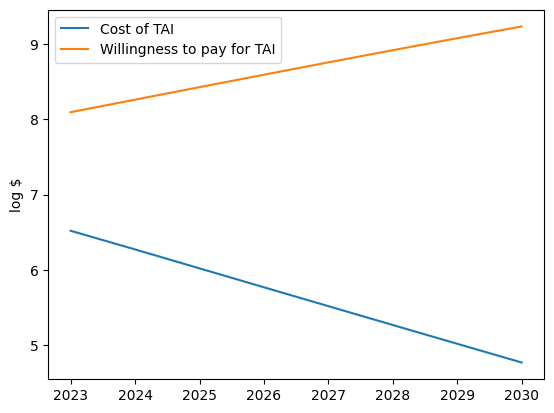

-
-
## SAMPLE RUN 18 ##
It takes 24.6 log FLOP (~4 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.4 years they get 2x cheaper, to a maximum of 23.1 log FLOP (~129 sextillion) per 2022$USD.
We are initially willing to pay 8.3 log 2022$USD (~193 million). This doubles every 4.6 years to a max of 0.025% of GDP (initially ~6 billion 2022$USD). GDP grows at a rate of 1.028x per year.
---
Year: 2023 - 26.5 max log FLOP (344 septillion) available - TAI takes 24.6 log FLOP (4 septillion) - log $ 6.3 to buy TAI (2 million) vs. willingness to pay log $ 8.3 (187 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.5)
-- algorithms p_nonscaling_issue p=0.4 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.8 -> Nonscaling issue did not occur
-- data p_nonscaling_issue p=0.0 -> Nonscaling issue did not occur
-- roboti

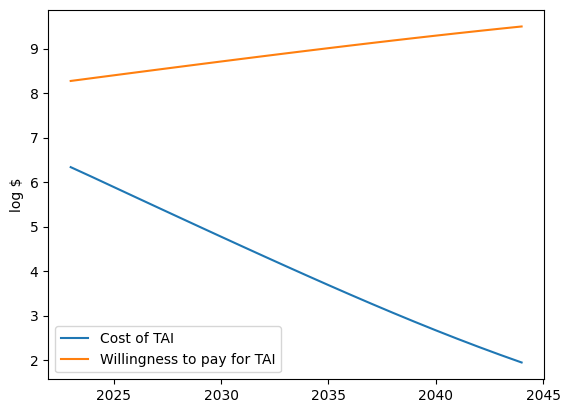

-
-
## SAMPLE RUN 19 ##
It takes 25.5 log FLOP (~32 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.7 log FLOP (~6 quintillion) per 2022$USD. Every 3.2 years they get 2x cheaper, to a maximum of 21.2 log FLOP (~2 sextillion) per 2022$USD.
We are initially willing to pay 8.3 log 2022$USD (~198 million). This doubles every 6.7 years to a max of 0.158059% of GDP (initially ~36 billion 2022$USD). GDP grows at a rate of 1.04x per year.
---
Year: 2023 - 27.0 max log FLOP (1 octillion) available - TAI takes 25.5 log FLOP (32 septillion) - log $ 6.8 to buy TAI (6 million) vs. willingness to pay log $ 8.3 (197 million) - 18.7 log FLOP per $ (6 quintillion) (Effective 2023-logFLOP: 27.0)
-- algorithms p_nonscaling_issue p=0.4 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.8 -> Nonscaling delay occured
-- -- this delay is 3 years (total delay 3 years)
-- data p_nonscaling_issue p=0.0

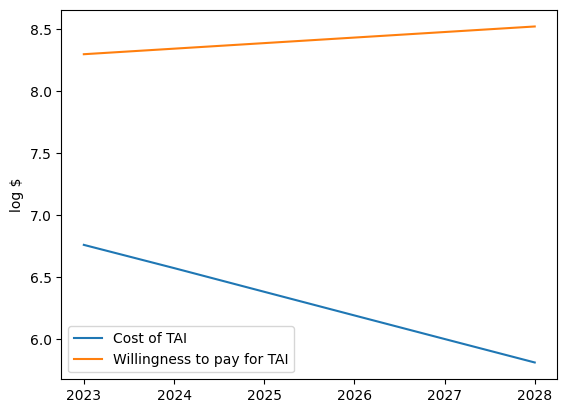

-
-
## SAMPLE RUN 20 ##
It takes 25.9 log FLOP (~79 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.8 log FLOP (~6 quintillion) per 2022$USD. Every 1.8 years they get 2x cheaper, to a maximum of 23.4 log FLOP (~228 sextillion) per 2022$USD.
We are initially willing to pay 8.8 log 2022$USD (~613 million). This doubles every 2.6 years to a max of 0.095718% of GDP (initially ~22 billion 2022$USD). GDP grows at a rate of 1.015x per year.
---
Year: 2023 - 27.5 max log FLOP (3 octillion) available - TAI takes 25.9 log FLOP (79 septillion) - log $ 7.1 to buy TAI (14 million) vs. willingness to pay log $ 8.8 (597 million) - 18.8 log FLOP per $ (6 quintillion) (Effective 2023-logFLOP: 27.5)
-- algorithms p_nonscaling_issue p=0.4 -> Nonscaling delay occured
-- -- this delay is 2 years (total delay 2 years)
-- infra p_nonscaling_issue p=0.8 -> Nonscaling delay occured
-- -- this delay is 3 years (total

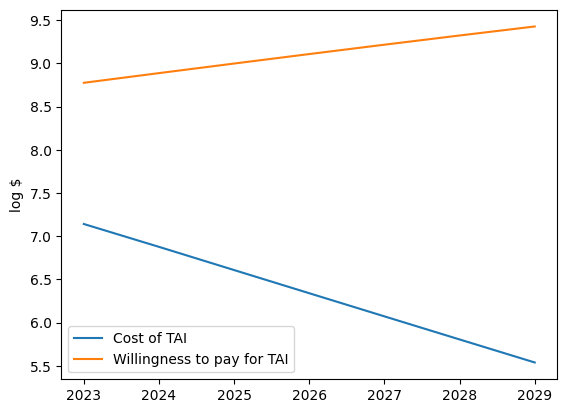

-
-
## SAMPLE RUN 21 ##
It takes 38.0 log FLOP (~100 thousand decillion) for transformative capabilities.
Every 1.0 years algorithms get 2x better, with 4 log reductions possible.
FLOP start at a cost of 17.8 log FLOP (~668 quadrillion) per 2022$USD. Every 2.2 years they get 2x cheaper, to a maximum of 22.6 log FLOP (~44 sextillion) per 2022$USD.
We are initially willing to pay 8.3 log 2022$USD (~197 million). This doubles every 2.8 years to a max of 0.060505% of GDP (initially ~14 billion 2022$USD). GDP grows at a rate of 1.03x per year.
---
Year: 2023 - 26.1 max log FLOP (130 septillion) available - TAI takes 38.0 log FLOP (100 thousand decillion) - log $ 20.2 to buy TAI (150 quintillion) vs. willingness to pay log $ 8.3 (194 million) - 17.8 log FLOP per $ (668 quadrillion) (Effective 2023-logFLOP: 26.1)
Year: 2024 - 26.4 max log FLOP (226 septillion) available - TAI takes 37.7 log FLOP (50 thousand decillion) - log $ 19.7 to buy TAI (55 quintillion) vs. willingness to pay log $ 8.4 

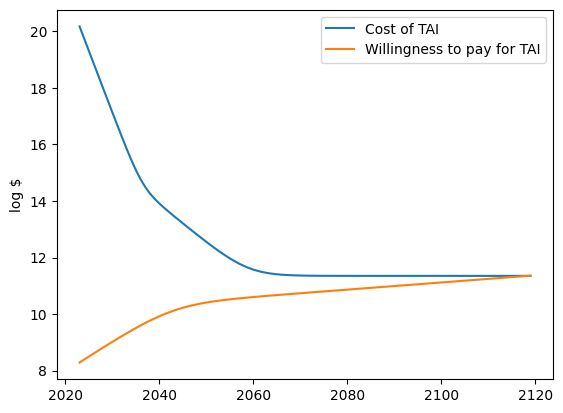

-
-
## SAMPLE RUN 22 ##
It takes 33.6 log FLOP (~4 decillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.5 log FLOP (~3 quintillion) per 2022$USD. Every 2.4 years they get 2x cheaper, to a maximum of 26.0 log FLOP (~111 septillion) per 2022$USD.
We are initially willing to pay 8.5 log 2022$USD (~307 million). This doubles every 1.6 years to a max of 0.048181% of GDP (initially ~11 billion 2022$USD). GDP grows at a rate of 1.012x per year.
---
Year: 2023 - 26.9 max log FLOP (857 septillion) available - TAI takes 33.6 log FLOP (4 decillion) - log $ 15.1 to buy TAI (1 quadrillion) vs. willingness to pay log $ 8.5 (299 million) - 18.5 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 26.9)
Year: 2024 - 27.2 max log FLOP (2 octillion) available - TAI takes 33.5 log FLOP (3 decillion) - log $ 14.9 to buy TAI (743 trillion) vs. willingness to pay log $ 8.7 (455 million) - 18.6 log FLOP per $ (4 qu

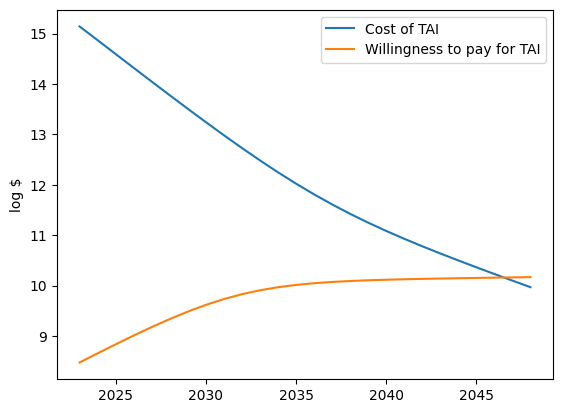

-
-
## SAMPLE RUN 23 ##
It takes 30.5 log FLOP (~3 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.5 log FLOP (~3 quintillion) per 2022$USD. Every 2.1 years they get 2x cheaper, to a maximum of 24.5 log FLOP (~3 septillion) per 2022$USD.
We are initially willing to pay 8.4 log 2022$USD (~242 million). This doubles every 3.1 years to a max of 0.030211% of GDP (initially ~7 billion 2022$USD). GDP grows at a rate of 1.026x per year.
---
Year: 2023 - 26.8 max log FLOP (706 septillion) available - TAI takes 30.5 log FLOP (3 nonillion) - log $ 12.0 to buy TAI (1 trillion) vs. willingness to pay log $ 8.4 (234 million) - 18.5 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 26.8)
Year: 2024 - 27.1 max log FLOP (1 octillion) available - TAI takes 30.4 log FLOP (2 nonillion) - log $ 11.8 to buy TAI (581 billion) vs. willingness to pay log $ 8.5 (290 million) - 18.6 log FLOP per $ (4 quintilli

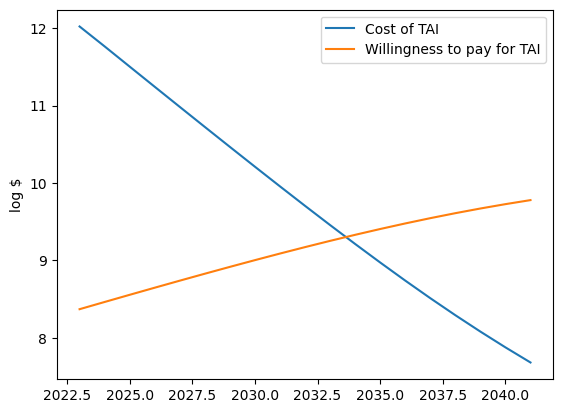

-
-
## SAMPLE RUN 24 ##
It takes 37.9 log FLOP (~79 thousand decillion) for transformative capabilities.
Every 1.0 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.6 log FLOP (~4 quintillion) per 2022$USD. Every 2.0 years they get 2x cheaper, to a maximum of 22.0 log FLOP (~11 sextillion) per 2022$USD.
We are initially willing to pay 8.5 log 2022$USD (~300 million). This doubles every 7.7 years to a max of 0.025% of GDP (initially ~6 billion 2022$USD). GDP grows at a rate of 1.022x per year.
---
Year: 2023 - 27.1 max log FLOP (1 octillion) available - TAI takes 37.9 log FLOP (79 thousand decillion) - log $ 19.3 to buy TAI (18 quintillion) vs. willingness to pay log $ 8.5 (285 million) - 18.6 log FLOP per $ (4 quintillion) (Effective 2023-logFLOP: 27.1)
Year: 2024 - 27.3 max log FLOP (2 octillion) available - TAI takes 37.6 log FLOP (40 thousand decillion) - log $ 18.8 to buy TAI (6 quintillion) vs. willingness to pay log $ 8.5 (311 million) - 1

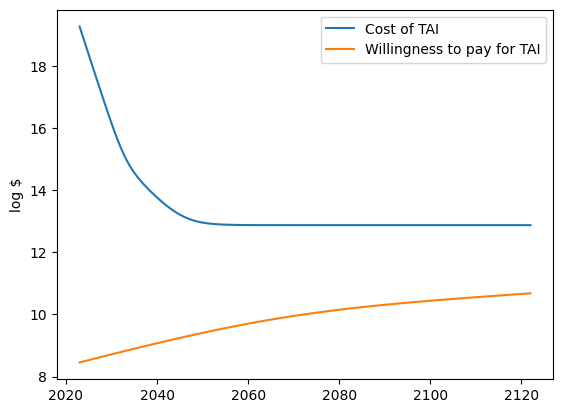

-
-
## SAMPLE RUN 25 ##
It takes 31.9 log FLOP (~79 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 19.1 log FLOP (~14 quintillion) per 2022$USD. Every 1.9 years they get 2x cheaper, to a maximum of 21.3 log FLOP (~2 sextillion) per 2022$USD.
We are initially willing to pay 8.4 log 2022$USD (~250 million). This doubles every 16.4 years to a max of 0.203099% of GDP (initially ~47 billion 2022$USD). GDP grows at a rate of 1.013x per year.
---
Year: 2023 - 27.5 max log FLOP (3 octillion) available - TAI takes 31.9 log FLOP (79 nonillion) - log $ 12.8 to buy TAI (6 trillion) vs. willingness to pay log $ 8.4 (249 million) - 19.1 log FLOP per $ (14 quintillion) (Effective 2023-logFLOP: 27.5)
Year: 2024 - 27.7 max log FLOP (5 octillion) available - TAI takes 31.8 log FLOP (61 nonillion) - log $ 12.5 to buy TAI (3 trillion) vs. willingness to pay log $ 8.4 (259 million) - 19.3 log FLOP per $ (20 quint

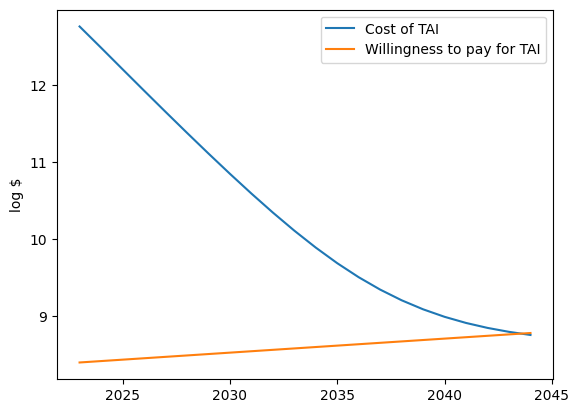

-
-
## SAMPLE RUN 26 ##
It takes 38.5 log FLOP (~316 thousand decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 4 log reductions possible.
FLOP start at a cost of 18.1 log FLOP (~1 quintillion) per 2022$USD. Every 2.6 years they get 2x cheaper, to a maximum of 24.7 log FLOP (~5 septillion) per 2022$USD.
We are initially willing to pay 8.5 log 2022$USD (~315 million). This doubles every 2.9 years to a max of 0.269721% of GDP (initially ~62 billion 2022$USD). GDP grows at a rate of 1.02x per year.
---
Year: 2023 - 26.6 max log FLOP (384 septillion) available - TAI takes 38.5 log FLOP (316 thousand decillion) - log $ 20.4 to buy TAI (258 quintillion) vs. willingness to pay log $ 8.5 (313 million) - 18.1 log FLOP per $ (1 quintillion) (Effective 2023-logFLOP: 26.6)
Year: 2024 - 26.8 max log FLOP (638 septillion) available - TAI takes 38.2 log FLOP (158 thousand decillion) - log $ 20.0 to buy TAI (99 quintillion) vs. willingness to pay log $ 8.6 (398 m

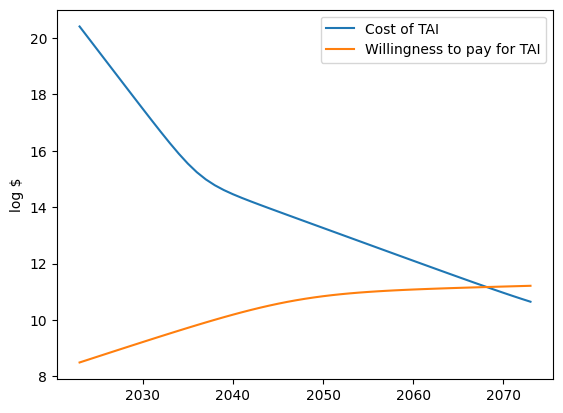

-
-
## SAMPLE RUN 27 ##
It takes 30.6 log FLOP (~4 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.1 log FLOP (~1 quintillion) per 2022$USD. Every 3.5 years they get 2x cheaper, to a maximum of 24.1 log FLOP (~1 septillion) per 2022$USD.
We are initially willing to pay 8.7 log 2022$USD (~487 million). This doubles every 6.4 years to a max of 0.076097% of GDP (initially ~18 billion 2022$USD). GDP grows at a rate of 1.024x per year.
---
Year: 2023 - 26.8 max log FLOP (597 septillion) available - TAI takes 30.6 log FLOP (4 nonillion) - log $ 12.5 to buy TAI (3 trillion) vs. willingness to pay log $ 8.7 (474 million) - 18.1 log FLOP per $ (1 quintillion) (Effective 2023-logFLOP: 26.8)
Year: 2024 - 26.9 max log FLOP (810 septillion) available - TAI takes 30.5 log FLOP (3 nonillion) - log $ 12.3 to buy TAI (2 trillion) vs. willingness to pay log $ 8.7 (527 million) - 18.2 log FLOP per $ (2 quinti

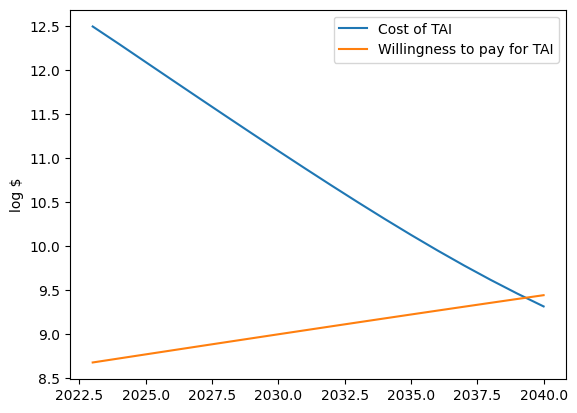

-
-
## SAMPLE RUN 28 ##
It takes 40.3 log FLOP (~20 million decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 3.0 log reductions possible.
FLOP start at a cost of 18.6 log FLOP (~4 quintillion) per 2022$USD. Every 2.9 years they get 2x cheaper, to a maximum of 22.1 log FLOP (~14 sextillion) per 2022$USD.
We are initially willing to pay 9.1 log 2022$USD (~1 billion). This doubles every 3.1 years to a max of 0.025% of GDP (initially ~6 billion 2022$USD). GDP grows at a rate of 1.018x per year.
---
Year: 2023 - 27.6 max log FLOP (4 octillion) available - TAI takes 40.3 log FLOP (20 million decillion) - log $ 21.7 to buy TAI (5 sextillion) vs. willingness to pay log $ 9.0 (1 billion) - 18.6 log FLOP per $ (4 quintillion) (Effective 2023-logFLOP: 27.6)
Year: 2024 - 27.8 max log FLOP (6 octillion) available - TAI takes 40.0 log FLOP (10 million decillion) - log $ 21.3 to buy TAI (2 sextillion) vs. willingness to pay log $ 9.1 (1 billion) - 18.7 log FLOP

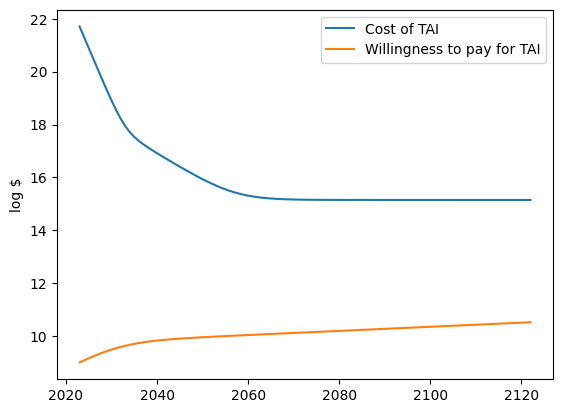

-
-
## SAMPLE RUN 29 ##
It takes 31.0 log FLOP (~10 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 19.2 log FLOP (~17 quintillion) per 2022$USD. Every 2.9 years they get 2x cheaper, to a maximum of 24.7 log FLOP (~6 septillion) per 2022$USD.
We are initially willing to pay 9.3 log 2022$USD (~2 billion). This doubles every 3.7 years to a max of 0.025% of GDP (initially ~6 billion 2022$USD). GDP grows at a rate of 1.03x per year.
---
Year: 2023 - 28.4 max log FLOP (25 octillion) available - TAI takes 31.0 log FLOP (10 nonillion) - log $ 11.8 to buy TAI (605 billion) vs. willingness to pay log $ 9.2 (2 billion) - 19.2 log FLOP per $ (17 quintillion) (Effective 2023-logFLOP: 28.4)
Year: 2024 - 28.6 max log FLOP (36 octillion) available - TAI takes 30.9 log FLOP (8 nonillion) - log $ 11.6 to buy TAI (367 billion) vs. willingness to pay log $ 9.2 (2 billion) - 19.3 log FLOP per $ (21 quintillion) (

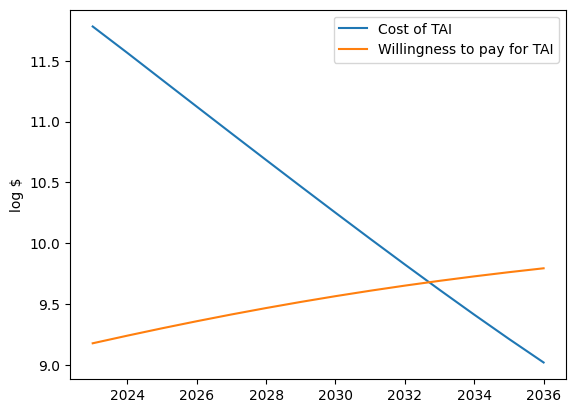

-
-
## SAMPLE RUN 30 ##
It takes 38.7 log FLOP (~501 thousand decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 4 log reductions possible.
FLOP start at a cost of 18.2 log FLOP (~1 quintillion) per 2022$USD. Every 3.3 years they get 2x cheaper, to a maximum of 22.5 log FLOP (~31 sextillion) per 2022$USD.
We are initially willing to pay 8.4 log 2022$USD (~247 million). This doubles every 1.8 years to a max of 0.057755% of GDP (initially ~13 billion 2022$USD). GDP grows at a rate of 1.042x per year.
---
Year: 2023 - 26.6 max log FLOP (358 septillion) available - TAI takes 38.7 log FLOP (501 thousand decillion) - log $ 20.5 to buy TAI (339 quintillion) vs. willingness to pay log $ 8.4 (242 million) - 18.2 log FLOP per $ (1 quintillion) (Effective 2023-logFLOP: 26.6)
Year: 2024 - 26.8 max log FLOP (646 septillion) available - TAI takes 38.4 log FLOP (251 thousand decillion) - log $ 20.1 to buy TAI (137 quintillion) vs. willingness to pay log $ 8.5 (35

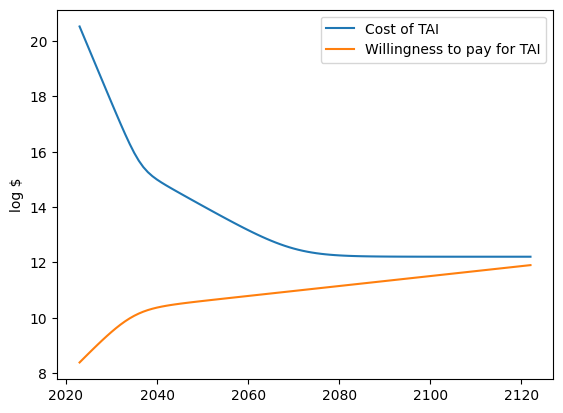

-
-
## SAMPLE RUN 31 ##
It takes 38.8 log FLOP (~631 thousand decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 4 log reductions possible.
FLOP start at a cost of 18.9 log FLOP (~8 quintillion) per 2022$USD. Every 1.7 years they get 2x cheaper, to a maximum of 24.3 log FLOP (~2 septillion) per 2022$USD.
We are initially willing to pay 8.9 log 2022$USD (~730 million). This doubles every 2.5 years to a max of 0.038891% of GDP (initially ~9 billion 2022$USD). GDP grows at a rate of 1.016x per year.
---
Year: 2023 - 27.8 max log FLOP (6 octillion) available - TAI takes 38.8 log FLOP (631 thousand decillion) - log $ 19.9 to buy TAI (75 quintillion) vs. willingness to pay log $ 8.8 (675 million) - 18.9 log FLOP per $ (8 quintillion) (Effective 2023-logFLOP: 27.8)
Year: 2024 - 28.0 max log FLOP (11 octillion) available - TAI takes 38.5 log FLOP (316 thousand decillion) - log $ 19.4 to buy TAI (25 quintillion) vs. willingness to pay log $ 8.9 (868 million

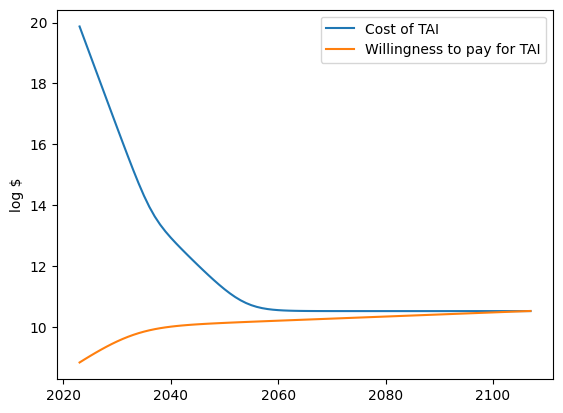

-
-
## SAMPLE RUN 32 ##
It takes 26.8 log FLOP (~631 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 19.4 log FLOP (~25 quintillion) per 2022$USD. Every 1.7 years they get 2x cheaper, to a maximum of 23.0 log FLOP (~93 sextillion) per 2022$USD.
We are initially willing to pay 8.5 log 2022$USD (~309 million). This doubles every 5.6 years to a max of 0.055754% of GDP (initially ~13 billion 2022$USD). GDP grows at a rate of 1.026x per year.
---
Year: 2023 - 27.9 max log FLOP (8 octillion) available - TAI takes 26.8 log FLOP (631 septillion) - log $ 7.4 to buy TAI (25 million) vs. willingness to pay log $ 8.5 (301 million) - 19.4 log FLOP per $ (25 quintillion) (Effective 2023-logFLOP: 27.9)
-- algorithms p_nonscaling_issue p=0.4 -> Nonscaling delay occured
-- -- this delay is 5 years (total delay 5 years)
-- infra p_nonscaling_issue p=0.8 -> Nonscaling delay occured
-- -- this delay is 7 years (to

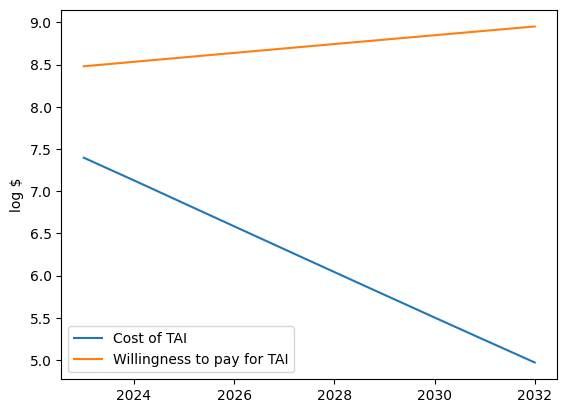

-
-
## SAMPLE RUN 33 ##
It takes 27.9 log FLOP (~8 octillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.4 log FLOP (~3 quintillion) per 2022$USD. Every 2.0 years they get 2x cheaper, to a maximum of 25.4 log FLOP (~24 septillion) per 2022$USD.
We are initially willing to pay 8.4 log 2022$USD (~250 million). This doubles every 3.1 years to a max of 0.204853% of GDP (initially ~47 billion 2022$USD). GDP grows at a rate of 1.015x per year.
---
Year: 2023 - 26.8 max log FLOP (682 septillion) available - TAI takes 27.9 log FLOP (8 octillion) - log $ 9.5 to buy TAI (3 billion) vs. willingness to pay log $ 8.4 (249 million) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 26.8)
Year: 2024 - 27.1 max log FLOP (1 octillion) available - TAI takes 27.8 log FLOP (6 octillion) - log $ 9.2 to buy TAI (2 billion) vs. willingness to pay log $ 8.5 (312 million) - 18.6 log FLOP per $ (4 quintillion) (

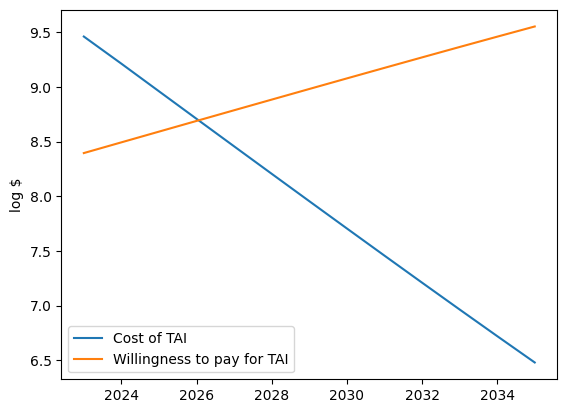

-
-
## SAMPLE RUN 34 ##
It takes 30.5 log FLOP (~3 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.2 years they get 2x cheaper, to a maximum of 24.6 log FLOP (~4 septillion) per 2022$USD.
We are initially willing to pay 9.1 log 2022$USD (~1 billion). This doubles every 8.6 years to a max of 0.025% of GDP (initially ~6 billion 2022$USD). GDP grows at a rate of 1.016x per year.
---
Year: 2023 - 27.3 max log FLOP (2 octillion) available - TAI takes 30.5 log FLOP (3 nonillion) - log $ 12.2 to buy TAI (2 trillion) vs. willingness to pay log $ 9.0 (1 billion) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.3)
Year: 2024 - 27.4 max log FLOP (3 octillion) available - TAI takes 30.4 log FLOP (2 nonillion) - log $ 12.0 to buy TAI (961 billion) vs. willingness to pay log $ 9.0 (1 billion) - 18.4 log FLOP per $ (3 quintillion) (Effecti

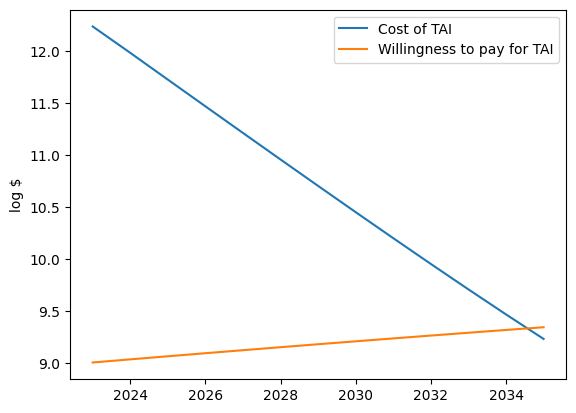

-
-
## SAMPLE RUN 35 ##
It takes 25.1 log FLOP (~13 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 1.6 years they get 2x cheaper, to a maximum of 23.9 log FLOP (~785 sextillion) per 2022$USD.
We are initially willing to pay 8.8 log 2022$USD (~569 million). This doubles every 4.8 years to a max of 0.025% of GDP (initially ~6 billion 2022$USD). GDP grows at a rate of 1.037x per year.
---
Year: 2023 - 27.1 max log FLOP (1 octillion) available - TAI takes 25.1 log FLOP (13 septillion) - log $ 6.8 to buy TAI (6 million) vs. willingness to pay log $ 8.7 (517 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.1)
-- algorithms p_nonscaling_issue p=0.4 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.8 -> Nonscaling issue did not occur
-- data p_nonscaling_issue p=0.0 -> Nonscaling issue did not occur
-- robotic

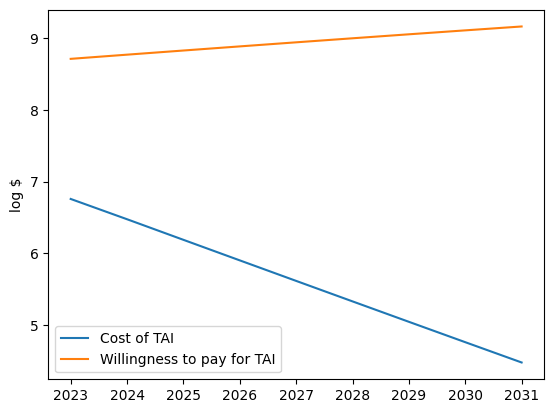

-
-
## SAMPLE RUN 36 ##
It takes 36.5 log FLOP (~3 thousand decillion) for transformative capabilities.
Every 1.0 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.2 log FLOP (~2 quintillion) per 2022$USD. Every 4.5 years they get 2x cheaper, to a maximum of 21.9 log FLOP (~8 sextillion) per 2022$USD.
We are initially willing to pay 8.8 log 2022$USD (~698 million). This doubles every 4.4 years to a max of 0.025% of GDP (initially ~6 billion 2022$USD). GDP grows at a rate of 1.032x per year.
---
Year: 2023 - 27.0 max log FLOP (1 octillion) available - TAI takes 36.5 log FLOP (3 thousand decillion) - log $ 18.3 to buy TAI (2 quintillion) vs. willingness to pay log $ 8.8 (622 million) - 18.2 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.0)
Year: 2024 - 27.1 max log FLOP (1 octillion) available - TAI takes 36.2 log FLOP (2 thousand decillion) - log $ 17.9 to buy TAI (840 quadrillion) vs. willingness to pay log $ 8.9 (718 million) - 18.3

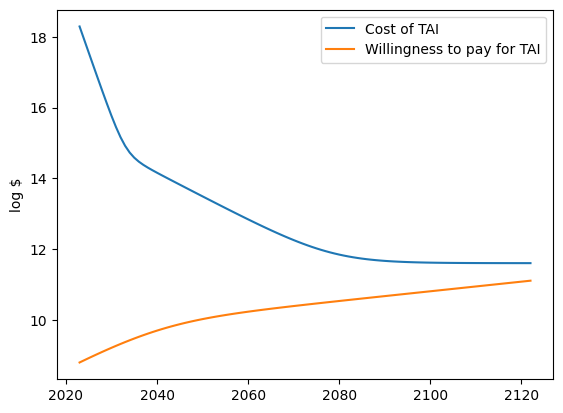

-
-
## SAMPLE RUN 37 ##
It takes 51.1 log FLOP (~1 quintillion decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 2.6 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 3.3 years they get 2x cheaper, to a maximum of 22.8 log FLOP (~57 sextillion) per 2022$USD.
We are initially willing to pay 8.8 log 2022$USD (~626 million). This doubles every 1.7 years to a max of 0.323126% of GDP (initially ~74 billion 2022$USD). GDP grows at a rate of 1.025x per year.
---
Year: 2023 - 27.1 max log FLOP (1 octillion) available - TAI takes 51.1 log FLOP (1 quintillion decillion) - log $ 32.8 to buy TAI (640 nonillion) vs. willingness to pay log $ 8.8 (620 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.1)
Year: 2024 - 27.4 max log FLOP (2 octillion) available - TAI takes 50.8 log FLOP (633 quadrillion decillion) - log $ 32.4 to buy TAI (260 nonillion) vs. willingness to pay log $ 9.0 (933 m

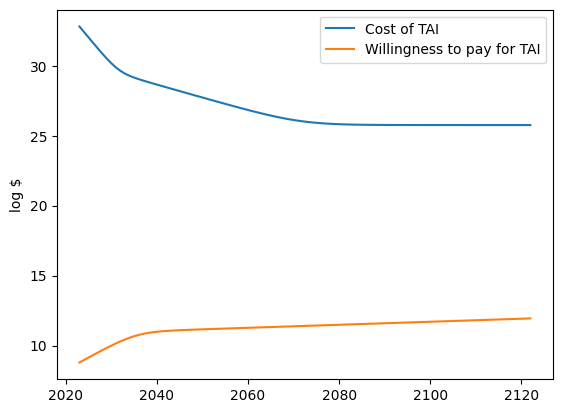

-
-
## SAMPLE RUN 38 ##
It takes 38.2 log FLOP (~158 thousand decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 4 log reductions possible.
FLOP start at a cost of 18.7 log FLOP (~5 quintillion) per 2022$USD. Every 2.1 years they get 2x cheaper, to a maximum of 27.9 log FLOP (~7 octillion) per 2022$USD.
We are initially willing to pay 8.7 log 2022$USD (~497 million). This doubles every 2.0 years to a max of 0.247885% of GDP (initially ~57 billion 2022$USD). GDP grows at a rate of 1.025x per year.
---
Year: 2023 - 27.4 max log FLOP (2 octillion) available - TAI takes 38.2 log FLOP (158 thousand decillion) - log $ 19.5 to buy TAI (34 quintillion) vs. willingness to pay log $ 8.7 (493 million) - 18.7 log FLOP per $ (5 quintillion) (Effective 2023-logFLOP: 27.4)
Year: 2024 - 27.7 max log FLOP (4 octillion) available - TAI takes 37.9 log FLOP (79 thousand decillion) - log $ 19.1 to buy TAI (12 quintillion) vs. willingness to pay log $ 8.8 (689 million) 

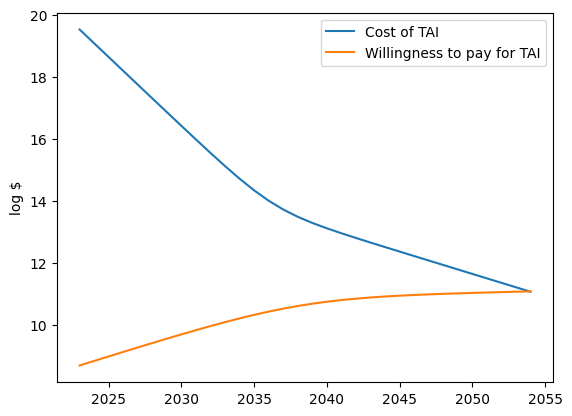

-
-
## SAMPLE RUN 39 ##
It takes 47.0 log FLOP (~100 trillion decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 6 log reductions possible.
FLOP start at a cost of 18.6 log FLOP (~4 quintillion) per 2022$USD. Every 2.1 years they get 2x cheaper, to a maximum of 20.6 log FLOP (~378 quintillion) per 2022$USD.
We are initially willing to pay 8.7 log 2022$USD (~461 million). This doubles every 5.4 years to a max of 0.025% of GDP (initially ~6 billion 2022$USD). GDP grows at a rate of 1.015x per year.
---
Year: 2023 - 27.2 max log FLOP (2 octillion) available - TAI takes 47.0 log FLOP (100 trillion decillion) - log $ 28.4 to buy TAI (27 octillion) vs. willingness to pay log $ 8.6 (427 million) - 18.6 log FLOP per $ (4 quintillion) (Effective 2023-logFLOP: 27.2)
Year: 2024 - 27.4 max log FLOP (3 octillion) available - TAI takes 46.7 log FLOP (50 trillion decillion) - log $ 28.0 to buy TAI (10 octillion) vs. willingness to pay log $ 8.7 (481 million) - 18

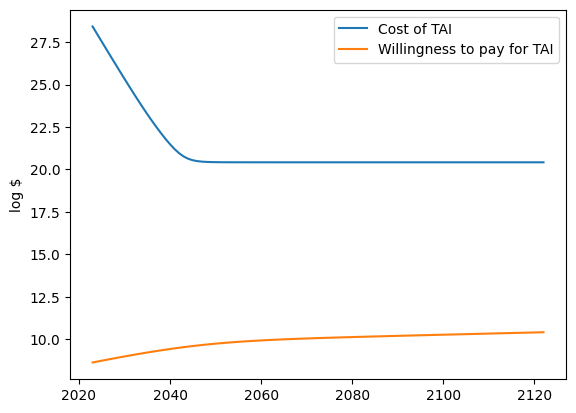

-
-
## SAMPLE RUN 40 ##
It takes 38.8 log FLOP (~631 thousand decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 4 log reductions possible.
FLOP start at a cost of 18.6 log FLOP (~4 quintillion) per 2022$USD. Every 2.7 years they get 2x cheaper, to a maximum of 22.0 log FLOP (~11 sextillion) per 2022$USD.
We are initially willing to pay 8.6 log 2022$USD (~380 million). This doubles every 1.0 years until 2025, and then doubles every 0.9 years to a max of 0.03555% of GDP (initially ~8 billion 2022$USD). GDP grows at a rate of 1.005x per year.
---
Year: 2023 - 27.2 max log FLOP (1 octillion) available - TAI takes 38.8 log FLOP (631 thousand decillion) - log $ 20.2 to buy TAI (154 quintillion) vs. willingness to pay log $ 8.6 (363 million) - 18.6 log FLOP per $ (4 quintillion) (Effective 2023-logFLOP: 27.2)
Year: 2024 - 27.6 max log FLOP (4 octillion) available - TAI takes 38.5 log FLOP (316 thousand decillion) - log $ 19.8 to buy TAI (59 quintillion) 

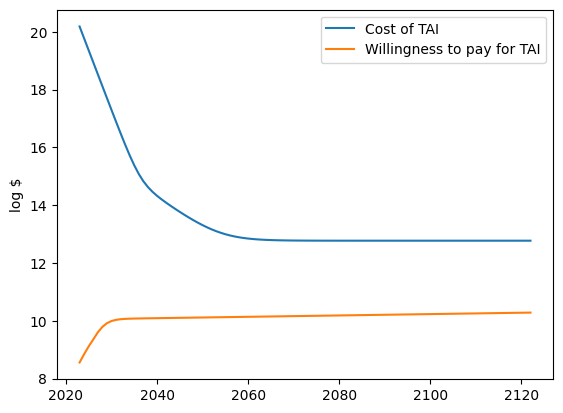

-
-
## SAMPLE RUN 41 ##
It takes 44.3 log FLOP (~200 billion decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 5 log reductions possible.
FLOP start at a cost of 19.1 log FLOP (~13 quintillion) per 2022$USD. Every 2.6 years they get 2x cheaper, to a maximum of 23.0 log FLOP (~101 sextillion) per 2022$USD.
We are initially willing to pay 8.9 log 2022$USD (~728 million). This doubles every 2.7 years to a max of 0.037965% of GDP (initially ~9 billion 2022$USD). GDP grows at a rate of 1.024x per year.
---
Year: 2023 - 27.9 max log FLOP (9 octillion) available - TAI takes 44.3 log FLOP (200 billion decillion) - log $ 25.2 to buy TAI (16 septillion) vs. willingness to pay log $ 8.8 (672 million) - 19.1 log FLOP per $ (13 quintillion) (Effective 2023-logFLOP: 27.9)
Year: 2024 - 28.2 max log FLOP (14 octillion) available - TAI takes 44.0 log FLOP (100 billion decillion) - log $ 24.8 to buy TAI (6 septillion) vs. willingness to pay log $ 8.9 (849 million) 

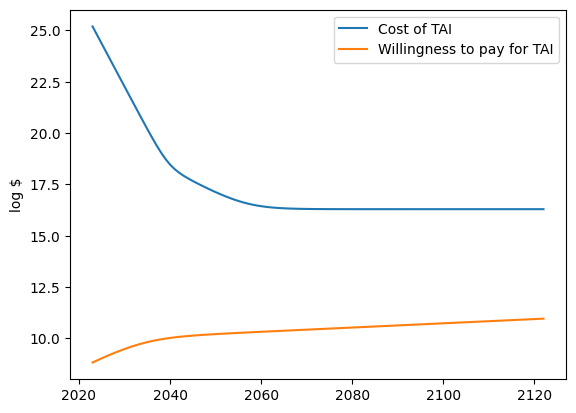

-
-
## SAMPLE RUN 42 ##
It takes 30.2 log FLOP (~2 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.0 log FLOP (~997 quadrillion) per 2022$USD. Every 2.6 years they get 2x cheaper, to a maximum of 25.4 log FLOP (~27 septillion) per 2022$USD.
We are initially willing to pay 9.2 log 2022$USD (~1 billion). This doubles every 1.4 years to a max of 0.025% of GDP (initially ~6 billion 2022$USD). GDP grows at a rate of 1.032x per year.
---
Year: 2023 - 27.1 max log FLOP (1 octillion) available - TAI takes 30.2 log FLOP (2 nonillion) - log $ 12.2 to buy TAI (2 trillion) vs. willingness to pay log $ 9.1 (1 billion) - 18.0 log FLOP per $ (997 quadrillion) (Effective 2023-logFLOP: 27.1)
Year: 2024 - 27.4 max log FLOP (2 octillion) available - TAI takes 30.1 log FLOP (1 nonillion) - log $ 12.0 to buy TAI (938 billion) vs. willingness to pay log $ 9.2 (2 billion) - 18.1 log FLOP per $ (1 quintillion) (Ef

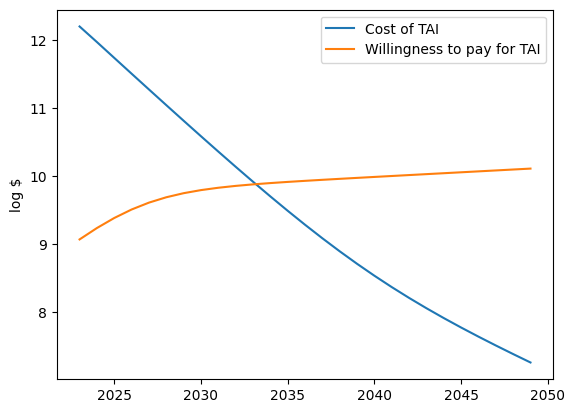

-
-
## SAMPLE RUN 43 ##
It takes 26.2 log FLOP (~158 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 1.6 years they get 2x cheaper, to a maximum of 23.6 log FLOP (~406 sextillion) per 2022$USD.
We are initially willing to pay 9.1 log 2022$USD (~1 billion). This doubles every 1.2 years to a max of 0.041747% of GDP (initially ~10 billion 2022$USD). GDP grows at a rate of 1.022x per year.
---
Year: 2023 - 27.4 max log FLOP (3 octillion) available - TAI takes 26.2 log FLOP (158 septillion) - log $ 7.9 to buy TAI (71 million) vs. willingness to pay log $ 9.1 (1 billion) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.4)
-- algorithms p_nonscaling_issue p=0.4 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.8 -> Nonscaling delay occured
-- -- this delay is 5 years (total delay 5 years)
-- data p_nonscaling_issue p=0

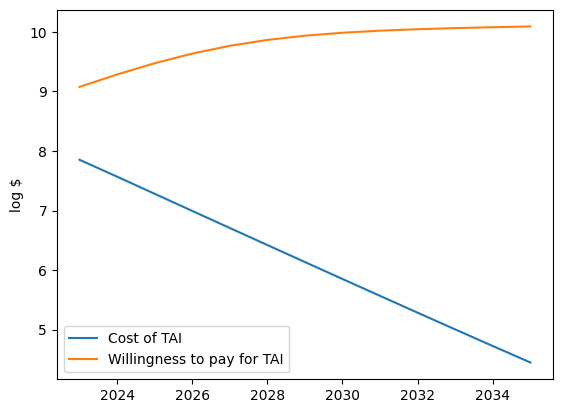

-
-
## SAMPLE RUN 44 ##
It takes 25.8 log FLOP (~63 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.7 log FLOP (~5 quintillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 22.3 log FLOP (~19 sextillion) per 2022$USD.
We are initially willing to pay 8.6 log 2022$USD (~378 million). This doubles every 1.7 years to a max of 0.032965% of GDP (initially ~8 billion 2022$USD). GDP grows at a rate of 1.031x per year.
---
Year: 2023 - 27.3 max log FLOP (2 octillion) available - TAI takes 25.8 log FLOP (63 septillion) - log $ 7.1 to buy TAI (12 million) vs. willingness to pay log $ 8.6 (360 million) - 18.7 log FLOP per $ (5 quintillion) (Effective 2023-logFLOP: 27.3)
-- algorithms p_nonscaling_issue p=0.4 -> Nonscaling delay occured
-- -- this delay is 3 years (total delay 3 years)
-- infra p_nonscaling_issue p=0.8 -> Nonscaling delay occured
-- -- this delay is 4 years (total d

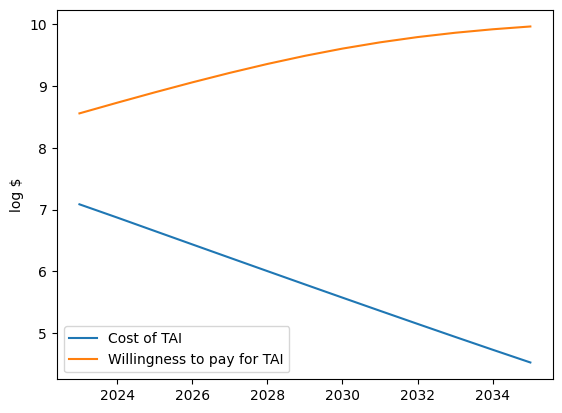

-
-
## SAMPLE RUN 45 ##
It takes 31.6 log FLOP (~40 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.4 log FLOP (~2 quintillion) per 2022$USD. Every 2.4 years they get 2x cheaper, to a maximum of 21.3 log FLOP (~2 sextillion) per 2022$USD.
We are initially willing to pay 8.5 log 2022$USD (~304 million). This doubles every 4.3 years to a max of 0.035262% of GDP (initially ~8 billion 2022$USD). GDP grows at a rate of 1.025x per year.
---
Year: 2023 - 26.8 max log FLOP (684 septillion) available - TAI takes 31.6 log FLOP (40 nonillion) - log $ 13.2 to buy TAI (17 trillion) vs. willingness to pay log $ 8.5 (293 million) - 18.4 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.8)
Year: 2024 - 27.0 max log FLOP (1 octillion) available - TAI takes 31.5 log FLOP (31 nonillion) - log $ 13.0 to buy TAI (10 trillion) vs. willingness to pay log $ 8.5 (343 million) - 18.5 log FLOP per $ (3 quint

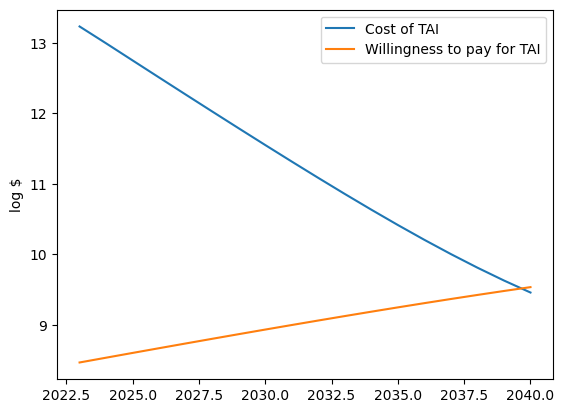

-
-
## SAMPLE RUN 46 ##
It takes 32.5 log FLOP (~316 nonillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.6 log FLOP (~4 quintillion) per 2022$USD. Every 1.6 years they get 2x cheaper, to a maximum of 22.9 log FLOP (~82 sextillion) per 2022$USD.
We are initially willing to pay 8.2 log 2022$USD (~156 million). This doubles every 2.6 years to a max of 0.041514% of GDP (initially ~10 billion 2022$USD). GDP grows at a rate of 1.023x per year.
---
Year: 2023 - 26.7 max log FLOP (560 septillion) available - TAI takes 32.5 log FLOP (316 nonillion) - log $ 13.9 to buy TAI (87 trillion) vs. willingness to pay log $ 8.2 (153 million) - 18.6 log FLOP per $ (4 quintillion) (Effective 2023-logFLOP: 26.7)
Year: 2024 - 27.0 max log FLOP (1 octillion) available - TAI takes 32.4 log FLOP (227 nonillion) - log $ 13.6 to buy TAI (40 trillion) vs. willingness to pay log $ 8.3 (200 million) - 18.7 log FLOP per $ (6 

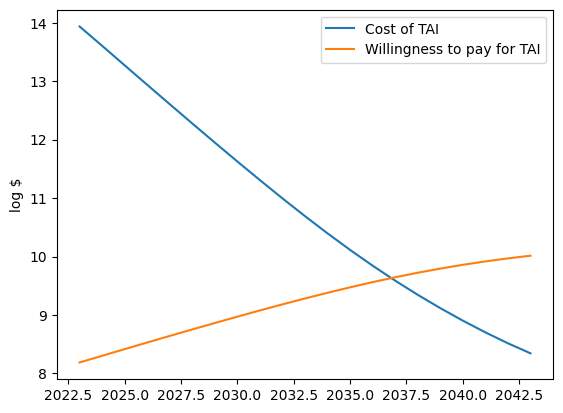

-
-
## SAMPLE RUN 47 ##
It takes 31.2 log FLOP (~16 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.2 log FLOP (~2 quintillion) per 2022$USD. Every 2.4 years they get 2x cheaper, to a maximum of 25.7 log FLOP (~54 septillion) per 2022$USD.
We are initially willing to pay 8.7 log 2022$USD (~462 million). This doubles every 5.8 years to a max of 0.025461% of GDP (initially ~6 billion 2022$USD). GDP grows at a rate of 1.027x per year.
---
Year: 2023 - 26.9 max log FLOP (731 septillion) available - TAI takes 31.2 log FLOP (16 nonillion) - log $ 13.0 to buy TAI (9 trillion) vs. willingness to pay log $ 8.6 (428 million) - 18.2 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.9)
Year: 2024 - 27.0 max log FLOP (1 octillion) available - TAI takes 31.1 log FLOP (12 nonillion) - log $ 12.7 to buy TAI (5 trillion) vs. willingness to pay log $ 8.7 (479 million) - 18.4 log FLOP per $ (2 quinti

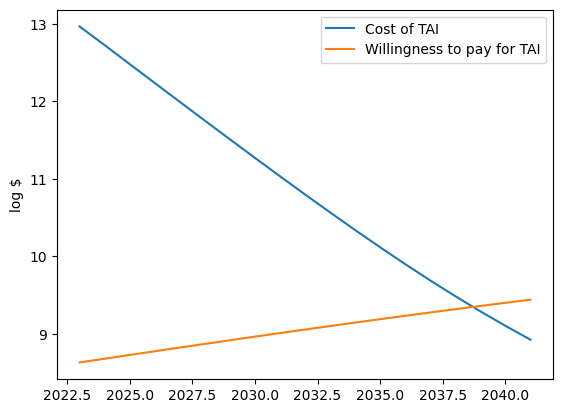

-
-
## SAMPLE RUN 48 ##
It takes 28.7 log FLOP (~50 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.5 log FLOP (~3 quintillion) per 2022$USD. Every 1.7 years they get 2x cheaper, to a maximum of 22.6 log FLOP (~37 sextillion) per 2022$USD.
We are initially willing to pay 8.7 log 2022$USD (~489 million). This doubles every 1.5 years to a max of 0.088261% of GDP (initially ~20 billion 2022$USD). GDP grows at a rate of 1.026x per year.
---
Year: 2023 - 27.2 max log FLOP (2 octillion) available - TAI takes 28.7 log FLOP (50 octillion) - log $ 10.2 to buy TAI (15 billion) vs. willingness to pay log $ 8.7 (478 million) - 18.5 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 27.2)
Year: 2024 - 27.6 max log FLOP (4 octillion) available - TAI takes 28.6 log FLOP (40 octillion) - log $ 9.9 to buy TAI (8 billion) vs. willingness to pay log $ 8.9 (755 million) - 18.7 log FLOP per $ (5 quintillio

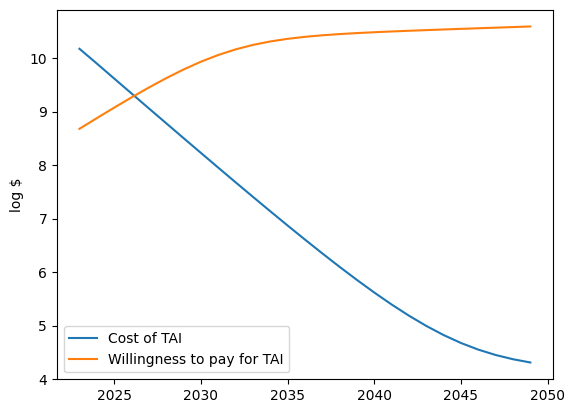

-
-
## SAMPLE RUN 49 ##
It takes 25.9 log FLOP (~79 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.5 log FLOP (~3 quintillion) per 2022$USD. Every 2.8 years they get 2x cheaper, to a maximum of 22.9 log FLOP (~71 sextillion) per 2022$USD.
We are initially willing to pay 8.6 log 2022$USD (~384 million). This doubles every 6.0 years to a max of 0.048298% of GDP (initially ~11 billion 2022$USD). GDP grows at a rate of 1.031x per year.
---
Year: 2023 - 27.1 max log FLOP (1 octillion) available - TAI takes 25.9 log FLOP (79 septillion) - log $ 7.4 to buy TAI (25 million) vs. willingness to pay log $ 8.6 (371 million) - 18.5 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 27.1)
-- algorithms p_nonscaling_issue p=0.4 -> Nonscaling delay occured
-- -- this delay is 3 years (total delay 3 years)
-- infra p_nonscaling_issue p=0.8 -> Nonscaling delay occured
-- -- this delay is 7 years (total 

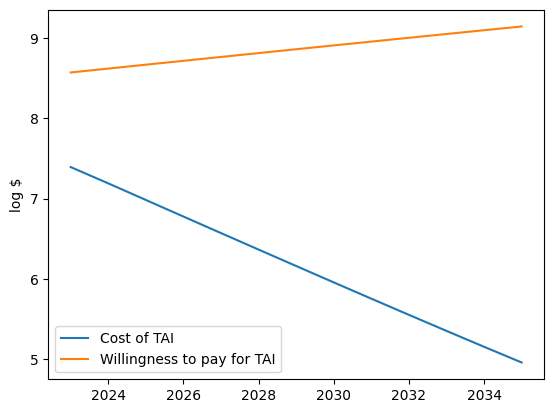

-
-
## SAMPLE RUN 50 ##
It takes 38.5 log FLOP (~316 thousand decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 4 log reductions possible.
FLOP start at a cost of 18.2 log FLOP (~1 quintillion) per 2022$USD. Every 2.7 years they get 2x cheaper, to a maximum of 22.8 log FLOP (~64 sextillion) per 2022$USD.
We are initially willing to pay 8.5 log 2022$USD (~300 million). This doubles every 3.6 years to a max of 0.025% of GDP (initially ~6 billion 2022$USD). GDP grows at a rate of 1.033x per year.
---
Year: 2023 - 26.6 max log FLOP (415 septillion) available - TAI takes 38.5 log FLOP (316 thousand decillion) - log $ 20.3 to buy TAI (217 quintillion) vs. willingness to pay log $ 8.5 (285 million) - 18.2 log FLOP per $ (1 quintillion) (Effective 2023-logFLOP: 26.6)
Year: 2024 - 26.8 max log FLOP (644 septillion) available - TAI takes 38.2 log FLOP (158 thousand decillion) - log $ 19.9 to buy TAI (84 quintillion) vs. willingness to pay log $ 8.5 (342 mil

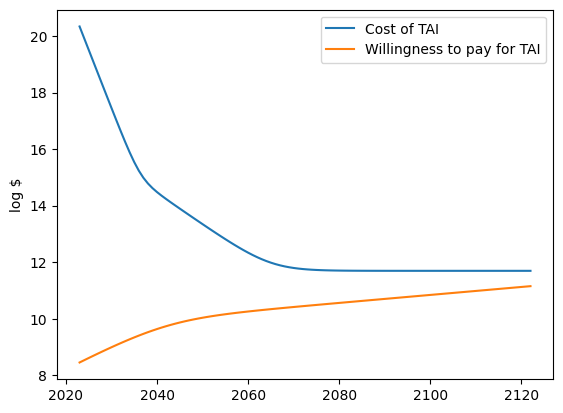

-
-
## SAMPLE RUN 51 ##
It takes 26.5 log FLOP (~316 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.8 log FLOP (~6 quintillion) per 2022$USD. Every 2.8 years they get 2x cheaper, to a maximum of 22.8 log FLOP (~67 sextillion) per 2022$USD.
We are initially willing to pay 8.8 log 2022$USD (~588 million). This doubles every 2.5 years to a max of 0.037688% of GDP (initially ~9 billion 2022$USD). GDP grows at a rate of 1.028x per year.
---
Year: 2023 - 27.6 max log FLOP (4 octillion) available - TAI takes 26.5 log FLOP (316 septillion) - log $ 7.7 to buy TAI (49 million) vs. willingness to pay log $ 8.7 (551 million) - 18.8 log FLOP per $ (6 quintillion) (Effective 2023-logFLOP: 27.6)
-- algorithms p_nonscaling_issue p=0.4 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.8 -> Nonscaling delay occured
-- -- this delay is 8 years (total delay 8 years)
-- data p_nonscaling_issue p

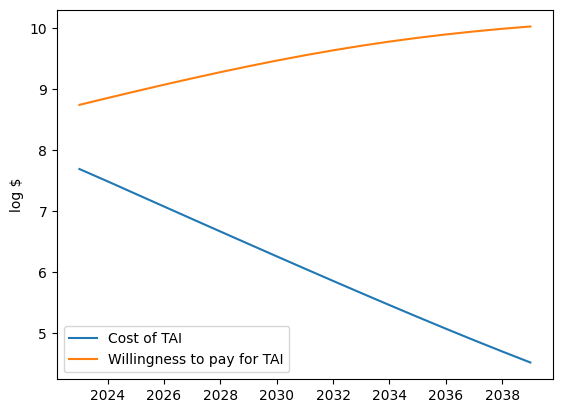

-
-
## SAMPLE RUN 52 ##
It takes 32.1 log FLOP (~126 nonillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.2 years they get 2x cheaper, to a maximum of 22.0 log FLOP (~11 sextillion) per 2022$USD.
We are initially willing to pay 8.5 log 2022$USD (~312 million). This doubles every 2.8 years to a max of 0.094658% of GDP (initially ~22 billion 2022$USD). GDP grows at a rate of 1.015x per year.
---
Year: 2023 - 26.8 max log FLOP (580 septillion) available - TAI takes 32.1 log FLOP (126 nonillion) - log $ 13.8 to buy TAI (67 trillion) vs. willingness to pay log $ 8.5 (307 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.8)
Year: 2024 - 27.0 max log FLOP (1 octillion) available - TAI takes 32.0 log FLOP (90 nonillion) - log $ 13.5 to buy TAI (35 trillion) vs. willingness to pay log $ 8.6 (391 million) - 18.4 log FLOP per $ (3 q

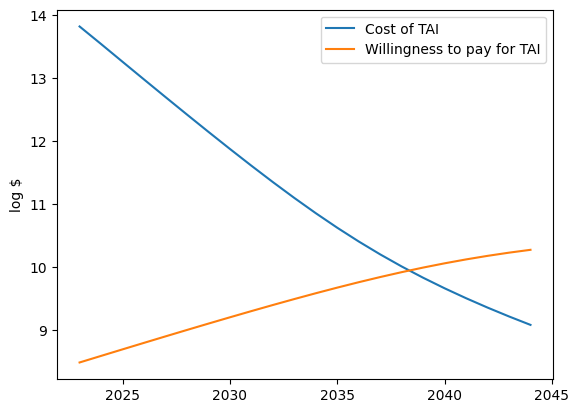

-
-
## SAMPLE RUN 53 ##
It takes 33.9 log FLOP (~8 decillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.4 log FLOP (~3 quintillion) per 2022$USD. Every 3.3 years they get 2x cheaper, to a maximum of 22.4 log FLOP (~25 sextillion) per 2022$USD.
We are initially willing to pay 9.4 log 2022$USD (~2 billion). This doubles every 1.1 years to a max of 0.036958% of GDP (initially ~9 billion 2022$USD). GDP grows at a rate of 1.016x per year.
---
Year: 2023 - 27.7 max log FLOP (5 octillion) available - TAI takes 33.9 log FLOP (8 decillion) - log $ 15.5 to buy TAI (3 quadrillion) vs. willingness to pay log $ 9.3 (2 billion) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 27.7)
Year: 2024 - 27.9 max log FLOP (9 octillion) available - TAI takes 33.8 log FLOP (6 decillion) - log $ 15.3 to buy TAI (2 quadrillion) vs. willingness to pay log $ 9.5 (3 billion) - 18.5 log FLOP per $ (3 quintillion)

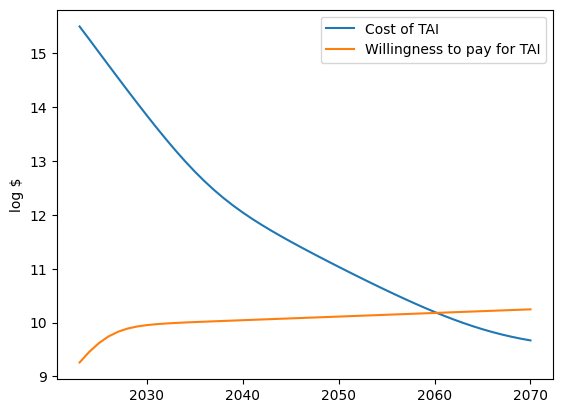

In [10]:
for i in range(50):
    print('-')
    print('-')
    print('## SAMPLE RUN {} ##'.format(i + 3 + 1))
    define_tai_timeline_event(variables, verbose=True)

In [11]:
print('File last ran: {}'.format(dt.now()))

File last ran: 2023-10-02 17:37:31.029971
